In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('future.no_silent_downcasting', True)

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
path = "./comodity-price-prediction-penyisihan-arkavidia-9/Harga Bahan Pangan/"
path_train = np.sort(os.listdir(path + "train"))
path_test = np.sort(os.listdir(path + "test"))

In [4]:
path_train

array(['Bawang Merah.csv', 'Bawang Putih Bonggol.csv', 'Beras Medium.csv',
       'Beras Premium.csv', 'Cabai Merah Keriting.csv',
       'Cabai Rawit Merah.csv', 'Daging Ayam Ras.csv',
       'Daging Sapi Murni.csv', 'Gula Konsumsi.csv',
       'Minyak Goreng Curah.csv', 'Minyak Goreng Kemasan Sederhana.csv',
       'Telur Ayam Ras.csv', 'Tepung Terigu (Curah).csv'], dtype='<U35')

In [5]:
path_train[0]

np.str_('Bawang Merah.csv')

In [6]:
df_train = [pd.read_csv(path + "train/" + data) for data in path_train]

for i, df_pangan in enumerate(df_train):
    df_pangan["Pangan"] = path_train[i].replace(".csv", "")

df_train = pd.concat(df_train, axis=0, ignore_index=True)
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_train = df_train.set_index("Date")

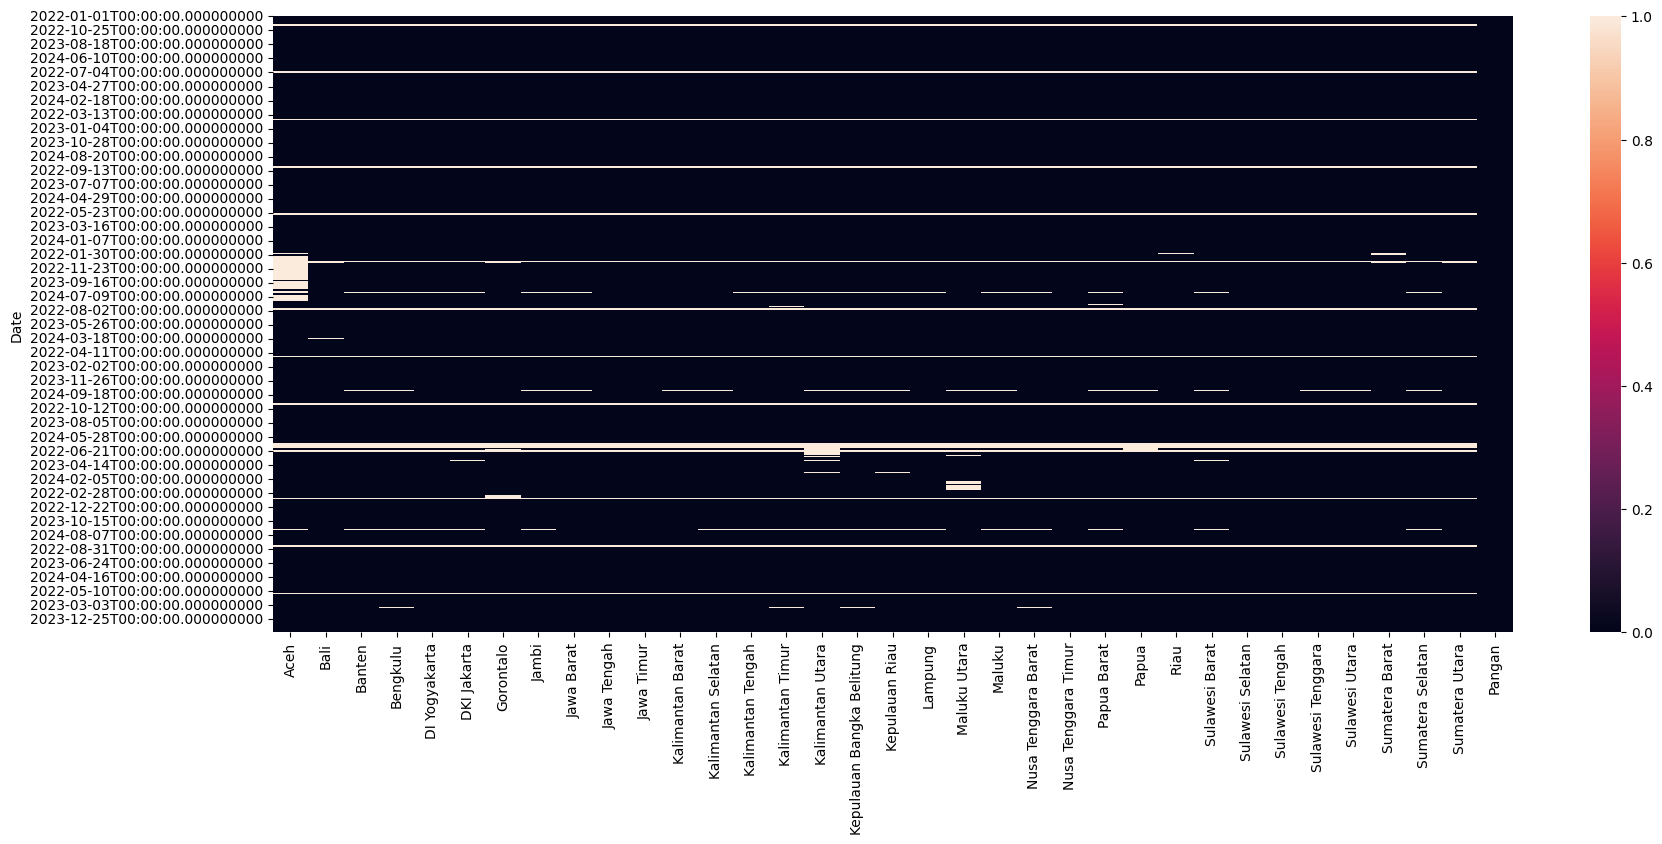

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(df_train.isna(), ax=ax);

In [8]:
list_provinsi = df_train.columns[:-1].to_list()

<Axes: xlabel='Date'>

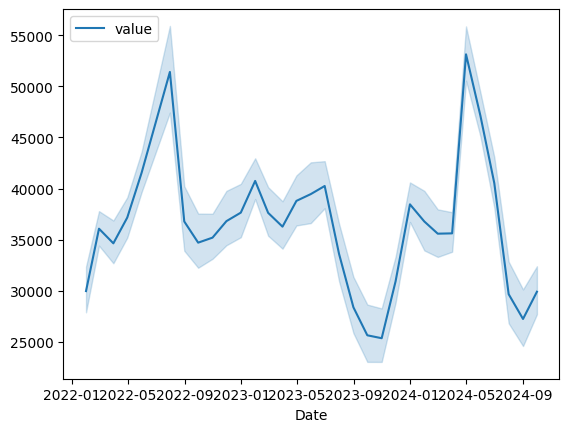

In [9]:
bawang_merah = df_train.loc[df_train["Pangan"] == "Bawang Merah", list_provinsi].asfreq("ME").T.melt().set_index("Date")
sns.lineplot(bawang_merah)

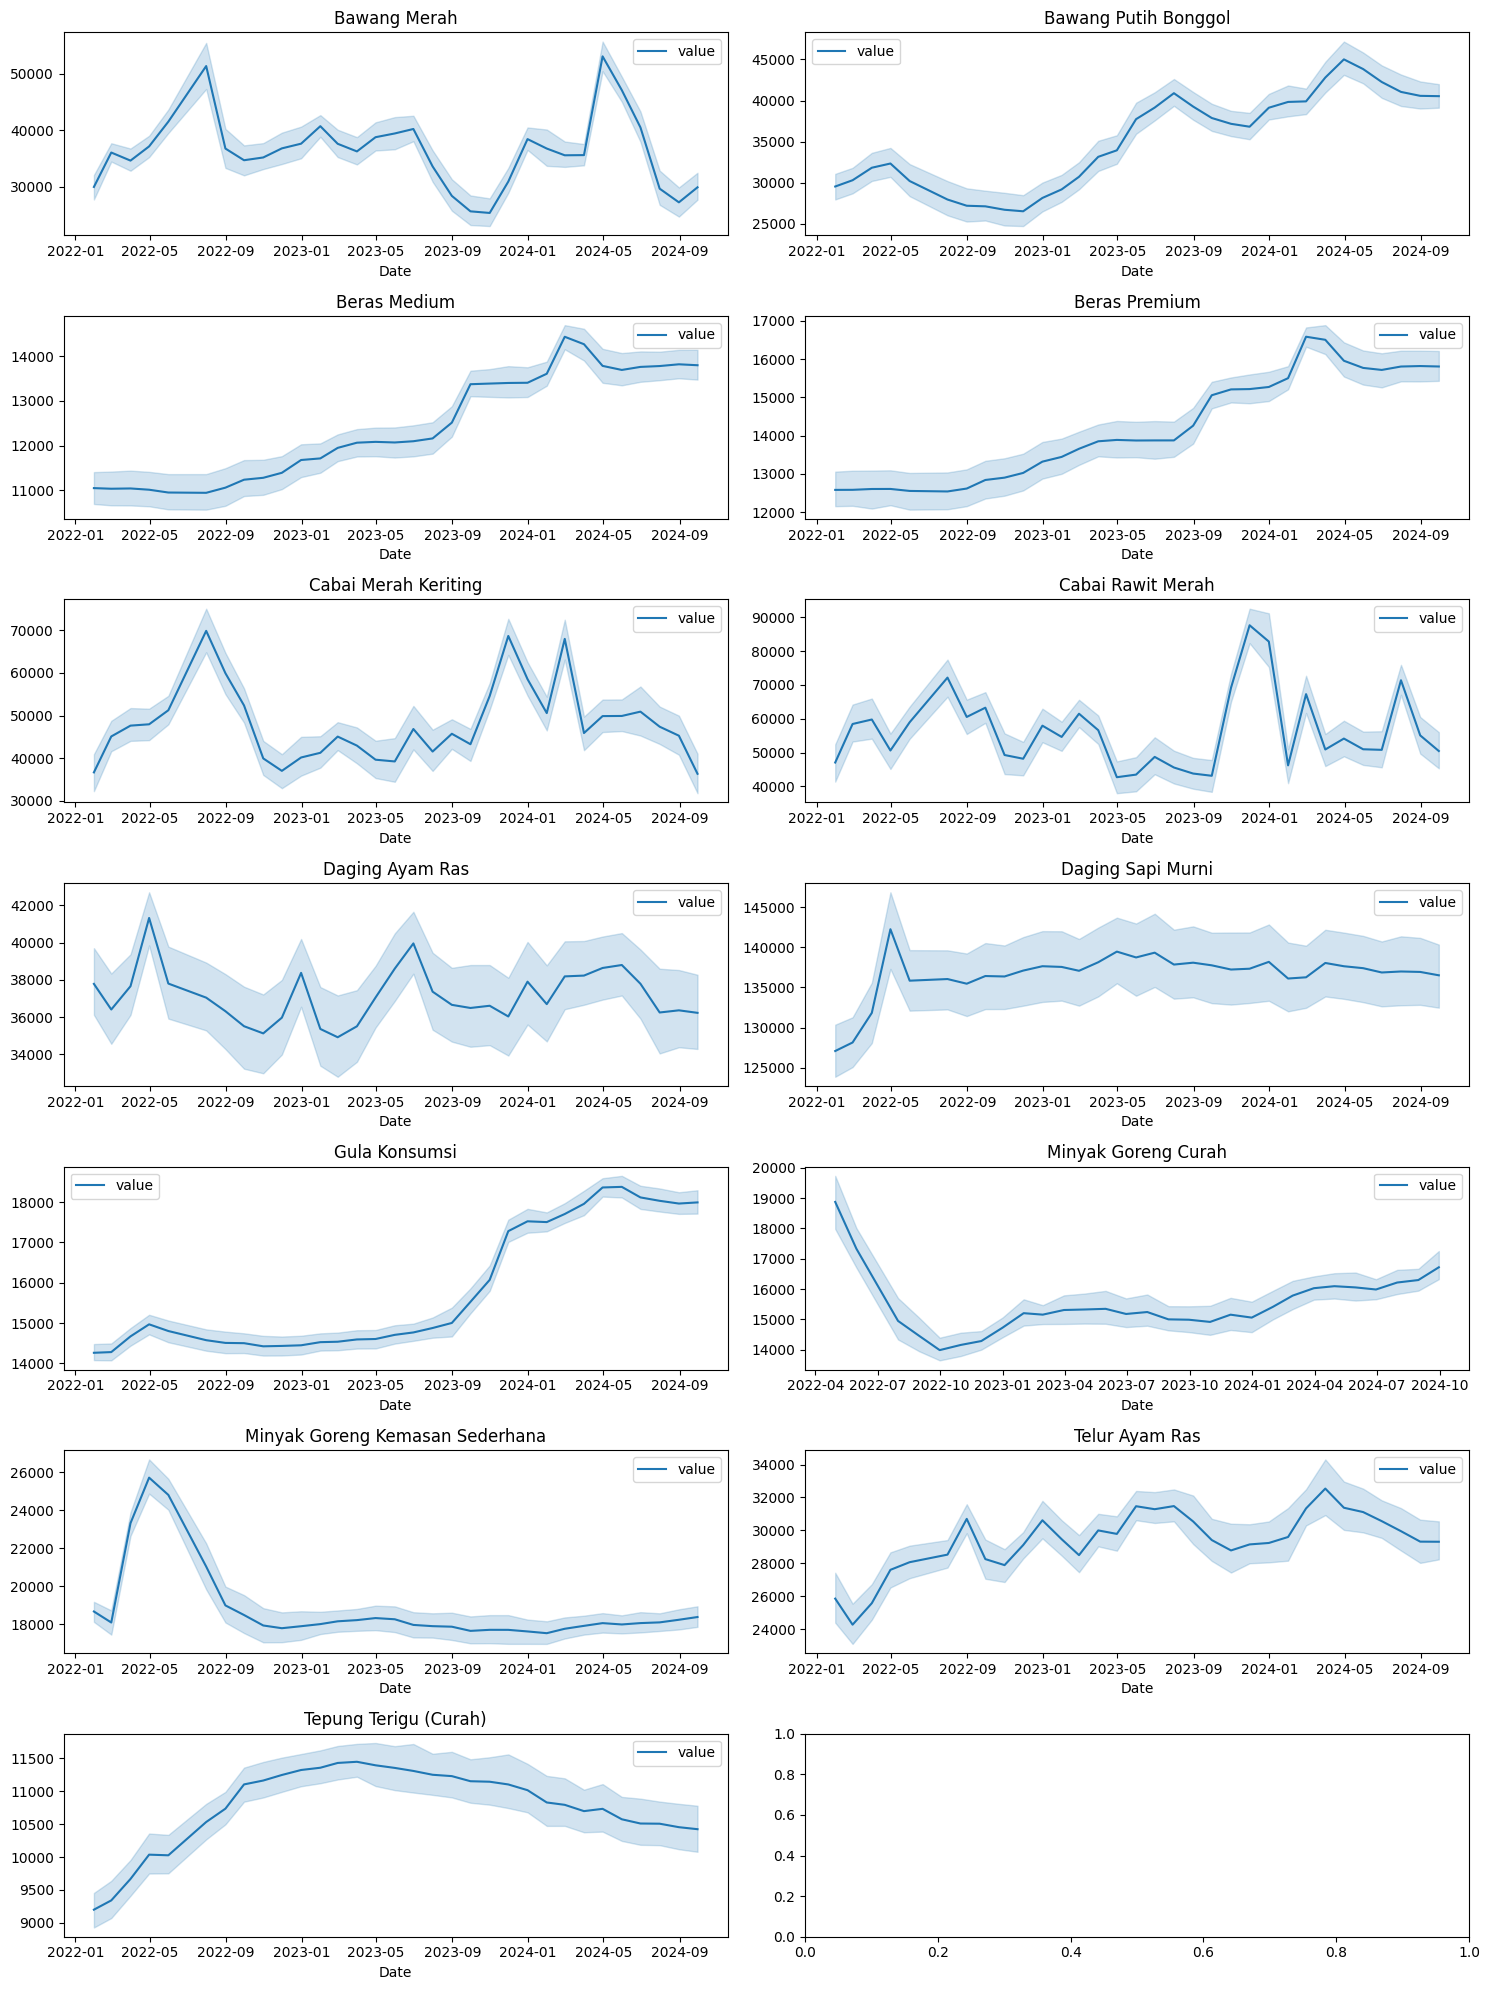

In [10]:
bahan_pangan = df_train["Pangan"].unique()

fig, ax = plt.subplots(int(len(bahan_pangan)/2) + 1, 2, figsize=(15, 20))
ax = ax.flatten()

for i, pangan in enumerate(bahan_pangan):
    groupby_pangan = df_train.loc[df_train["Pangan"] == pangan, list_provinsi].asfreq("ME").T.melt().set_index("Date")
    sns.lineplot(groupby_pangan, ax=ax[i])
    ax[i].title.set_text(pangan)
    
plt.tight_layout()

In [11]:
import copy
from sklearn.impute import KNNImputer

In [12]:
for pangan in bahan_pangan:
    pangan_df = df_train[df_train["Pangan"] == pangan]
    for prov in list_provinsi:
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].interpolate(method="time")
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].bfill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].ffill()
        df_train.loc[df_train["Pangan"] == pangan, prov] = df_train.loc[df_train["Pangan"] == pangan, prov].round(-1)
        

In [13]:
# model_xgb = xgb.XGBRegressor(n_estimators=50, learning_rate=0.1)

# for pangan in bahan_pangan:
#     pangan_df = df_train[df_train["Pangan"] == pangan]
#     pangan_df = pangan_df.drop(columns=["Pangan"])
#     for prov in list_provinsi:
#         train_data = pangan_df.dropna()
#         test_data = pangan_df[pangan_df[prov].isna()]
#         test_data = test_data.drop(columns=[prov])
    
#         train_x = train_data.drop(columns=[prov])
#         train_y = train_data[prov]

#         model_xgb.fit(train_x, train_y)

#         missing_pred = model_xgb.predict(test_data)
        
#         df_train.loc[(df_train["Pangan"] == pangan) & (df_train[prov].isna()), prov] = missing_pred

In [14]:
from sklearn.metrics import mean_absolute_percentage_error
import logging
from sklearn.preprocessing import MinMaxScaler

In [15]:
df_train = df_train.reset_index().rename(columns={"Date":"ds"})

In [16]:
path_commodity = "./comodity-price-prediction-penyisihan-arkavidia-9/Global Commodity Price/"
path_commodity_list = os.listdir(path_commodity)

commodity_df = [pd.read_csv(path_commodity + path)[["Date","Price"]].sort_values("Date") for path in path_commodity_list] 

for i, df_commodity in enumerate(commodity_df):
    df_commodity["Commodity"] = path_commodity_list[i].replace(".csv", "")

rename_commodity = {"Crude Oil WTI Futures Historical Data" : 1, 
                    "Natural Gas Futures Historical Data" : 2, 
                    "Newcastle Coal Futures Historical Data" : 3, 
                    "Palm Oil Futures Historical Data" : 4, 
                    "US Sugar 11 Futures Historical Data" : 5, 
                    "US Wheat Futures Historical Data" : 6}

commodity_df = pd.concat(commodity_df, axis=0, ignore_index=True)
commodity_df = commodity_df.rename(columns={"Date":"ds"})

commodity_df["ds"] = pd.to_datetime(commodity_df["ds"])
commodity_df["Commodity"] = commodity_df["Commodity"].replace(rename_commodity)
commodity_df["Price"] = commodity_df["Price"].apply(lambda x : str(x).replace(",", "")).astype(np.float64)

In [17]:
for i in range(1, 7):
    commodity = commodity_df[commodity_df["Commodity"] == i][["ds", "Price"]].rename(columns={"Price" : f"Com{i}"}).reset_index(drop=True)
    commodity_df = pd.merge(commodity_df, commodity, on="ds", sort=True)
    
commodity_df = commodity_df.drop(columns=["Price", "Commodity"])
commodity_df = commodity_df.drop_duplicates().reset_index(drop=True)

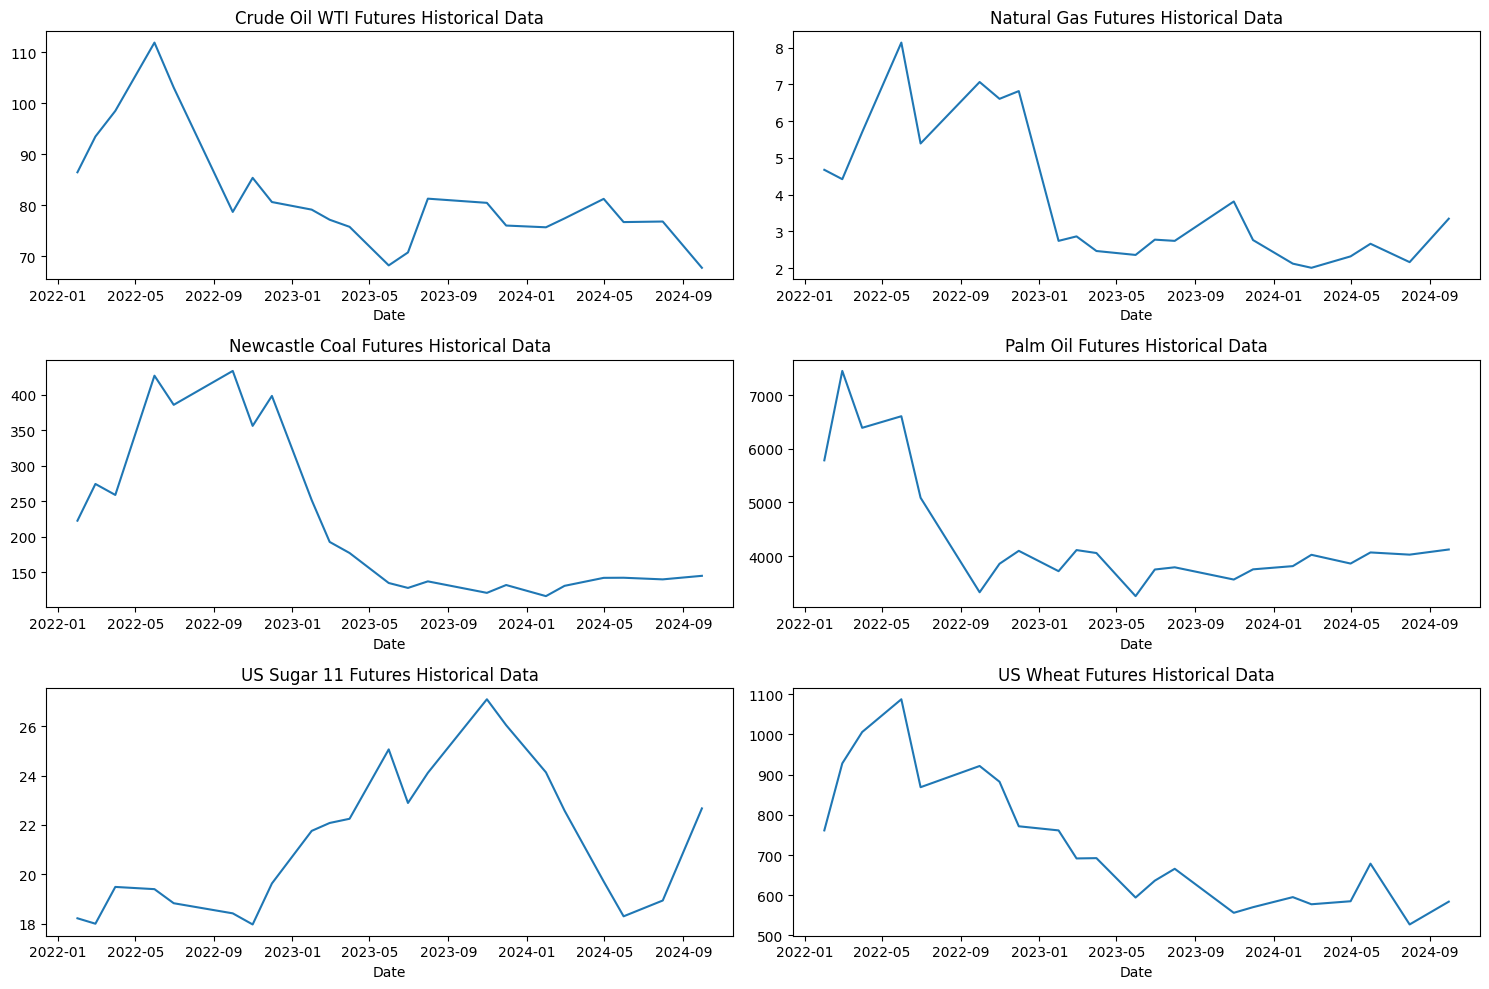

In [18]:
plt.figure(figsize=(15, 10))

for i in range(1, 7):
    plt.subplot(3, 2, i)
    sns.lineplot(commodity_df.set_index("ds").asfreq("ME"),x="ds", y=f"Com{i}")
    plt.xlabel("Date")
    plt.ylabel("")
    plt.title(f"{list(rename_commodity.keys())[i - 1]}")
    
plt.tight_layout()

In [19]:
path_exchange = "./comodity-price-prediction-penyisihan-arkavidia-9/Mata Uang/"
path_exchange_list = os.listdir(path_exchange)

exchange_list = {"MYRUSD=X" : "MYR", "SGDUSD=X" : "SGD", "THUSD=X" : "THB", "USDIDR=X" : "IDR"}

exchange_df = [pd.read_csv(path_exchange + path)[["Date","Adj Close"]].sort_values("Date") for path in path_exchange_list]

for i, df_exchange in enumerate(exchange_df):
    exchange_name = path_exchange_list[i].replace(".csv", "")
    exchange_df[i] = df_exchange.rename(columns={"Adj Close" : exchange_name})
    if i > 0:
        exchange_df[i] = exchange_df[i].drop(columns=["Date"])
    
df_exchange = pd.concat(exchange_df, axis=1)
df_exchange = df_exchange.rename(columns=exchange_list)
df_exchange = df_exchange.rename(columns={"Date":"ds"})
df_exchange["ds"] = pd.to_datetime(df_exchange["ds"])
df_exchange

,ds,MYR,SGD,THBUSD=X,IDR
0,2022-01-03,0.239521,0.741730,0.030201,14215.000000
1,2022-01-04,0.239808,0.739033,0.030082,14283.599609
2,2022-01-05,0.239006,0.737621,0.030083,14385.500000
3,2022-01-06,0.238550,0.736534,0.030077,14446.500000
4,2022-01-07,0.237473,0.734786,0.029804,14408.000000
...,...,...,...,...,...
711,2024-09-24,0.238067,0.774647,0.030377,15174.099609
712,2024-09-25,0.240964,0.779812,0.030710,15121.099609
713,2024-09-26,0.242219,0.775326,0.030516,15201.500000
714,2024-09-27,0.241546,0.778889,0.030897,15070.000000


### LSTM Model

In [20]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeXer, TFT, TiDE, LSTM
from neuralforecast.losses.pytorch import MAPE

C:\Users\Yani Dwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-14 23:09:18,363	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-14 23:09:20,052	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [21]:
ypred_list = []
id_list = []
for bahan in bahan_pangan:
    print("=" * 5,bahan, "=" * 5)
    for prov in list_provinsi:
        print(prov)
        df_prov_train = df_train[df_train["Pangan"] == bahan][["ds", prov]]
        df_prov_train = df_prov_train.rename(columns={prov:"y"})
        
        val_size = int(len(df_prov_train) * 0.15)
        corr_tolerance = 0.3
        
        df_prov_train = pd.merge(df_prov_train, commodity_df, on="ds", how="left")
        df_prov_train = pd.merge(df_prov_train, df_exchange, on="ds", how="left")
        
        corr_features = df_prov_train.corr()["y"][2:]
        corr_features = corr_features[np.abs(corr_features) > corr_tolerance].index.to_list()
        corr_features.insert(0, "ds")
        corr_features.insert(1, "y")
        
        df_prov_train = df_prov_train[corr_features]
        df_prov_train = df_prov_train.set_index("ds")
        
        df_prov_train = df_prov_train.interpolate(method="time")
        df_prov_train = df_prov_train.bfill()
        df_prov_train = df_prov_train.ffill()
        df_prov_train = df_prov_train.reset_index()
        
        for ex in corr_features[2:]:     
            scaler = MinMaxScaler()
            df_prov_train[ex] = scaler.fit_transform(df_prov_train[[ex]])
    
        df_futures = pd.read_csv(path + f"test/Gula Konsumsi.csv").rename(columns={"Date":"ds"})[["ds"]]
        df_futures = pd.to_datetime(df_futures["ds"])
        df_futures = df_futures.reset_index().rename(columns={"index":"unique_id"})
        df_futures["unique_id"] = 1
            
        df_prov_train = df_prov_train.reset_index().rename(columns={"index":"unique_id"})
        df_prov_train["unique_id"] = 1
        
        model_timexer = LSTM(h=len(df_futures),
                            input_size=val_size + 12,
                            loss=MAPE(),
                            valid_loss = MAPE(),
                            max_steps=100,
                            val_check_steps=10,
                            encoder_n_layers=2,
                            encoder_hidden_size=128,
                            decoder_hidden_size=128,
                            decoder_layers=2,
                            scaler_type='robust',
                            hist_exog_list=corr_features[2:],
                            batch_size=128
                            )
    
        forecast = NeuralForecast(
            models=[model_timexer],
            freq="D"
        )
        
        forecast.fit(df_prov_train, val_size=val_size, verbose=False)
        ypred = forecast.predict(futr_df=df_futures, verbose=False)
        
        id_name = df_futures["ds"].apply(lambda x : f"{bahan}/{prov}/{str(x)}")
        id_list.append(np.array(id_name))
        
        ypred_list.append(np.array(ypred))

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


===== Bawang Merah =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.14it/s, v_num=2754, train_loss_step=0.798, train_loss_epoch=0.798, valid_loss=0.353]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s, v_num=2754, train_loss_step=0.798, train_loss_epoch=0.798, valid_loss=0.353]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.72it/s]
Bali


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.42it/s, v_num=2756, train_loss_step=0.847, train_loss_epoch=0.847, valid_loss=0.217]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s, v_num=2756, train_loss_step=0.847, train_loss_epoch=0.847, valid_loss=0.217]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.09it/s]
Banten


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.56it/s, v_num=2758, train_loss_step=0.834, train_loss_epoch=0.834, valid_loss=0.130]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=2758, train_loss_step=0.834, train_loss_epoch=0.834, valid_loss=0.130]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Bengkulu


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s, v_num=2760, train_loss_step=0.746, train_loss_epoch=0.746, valid_loss=0.287]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.01it/s, v_num=2760, train_loss_step=0.746, train_loss_epoch=0.746, valid_loss=0.287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.55it/s]
DI Yogyakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s, v_num=2762, train_loss_step=0.774, train_loss_epoch=0.774, valid_loss=0.285]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s, v_num=2762, train_loss_step=0.774, train_loss_epoch=0.774, valid_loss=0.285]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.91it/s]
DKI Jakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s, v_num=2764, train_loss_step=0.842, train_loss_epoch=0.842, valid_loss=0.195]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s, v_num=2764, train_loss_step=0.842, train_loss_epoch=0.842, valid_loss=0.195]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]
Gorontalo


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s, v_num=2766, train_loss_step=0.905, train_loss_epoch=0.905, valid_loss=0.290]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, v_num=2766, train_loss_step=0.905, train_loss_epoch=0.905, valid_loss=0.290]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.83it/s]
Jambi


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.54it/s, v_num=2768, train_loss_step=0.607, train_loss_epoch=0.607, valid_loss=0.281]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s, v_num=2768, train_loss_step=0.607, train_loss_epoch=0.607, valid_loss=0.281]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.85it/s]
Jawa Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.89it/s, v_num=2770, train_loss_step=0.929, train_loss_epoch=0.929, valid_loss=0.198]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s, v_num=2770, train_loss_step=0.929, train_loss_epoch=0.929, valid_loss=0.198]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.03it/s]
Jawa Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s, v_num=2772, train_loss_step=0.848, train_loss_epoch=0.848, valid_loss=0.254]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s, v_num=2772, train_loss_step=0.848, train_loss_epoch=0.848, valid_loss=0.254]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.24it/s]
Jawa Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.34it/s, v_num=2774, train_loss_step=0.881, train_loss_epoch=0.881, valid_loss=0.289]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s, v_num=2774, train_loss_step=0.881, train_loss_epoch=0.881, valid_loss=0.289]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
Kalimantan Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.49it/s, v_num=2776, train_loss_step=0.860, train_loss_epoch=0.860, valid_loss=0.180]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s, v_num=2776, train_loss_step=0.860, train_loss_epoch=0.860, valid_loss=0.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]
Kalimantan Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s, v_num=2778, train_loss_step=0.740, train_loss_epoch=0.740, valid_loss=0.257]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s, v_num=2778, train_loss_step=0.740, train_loss_epoch=0.740, valid_loss=0.257]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.90it/s]
Kalimantan Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s, v_num=2780, train_loss_step=0.687, train_loss_epoch=0.687, valid_loss=0.253]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, v_num=2780, train_loss_step=0.687, train_loss_epoch=0.687, valid_loss=0.253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.52it/s]
Kalimantan Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s, v_num=2782, train_loss_step=0.888, train_loss_epoch=0.888, valid_loss=0.200]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s, v_num=2782, train_loss_step=0.888, train_loss_epoch=0.888, valid_loss=0.200]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Kalimantan Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s, v_num=2784, train_loss_step=0.797, train_loss_epoch=0.797, valid_loss=0.191]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s, v_num=2784, train_loss_step=0.797, train_loss_epoch=0.797, valid_loss=0.191]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.34it/s]
Kepulauan Bangka Belitung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.42it/s, v_num=2786, train_loss_step=0.945, train_loss_epoch=0.945, valid_loss=0.326]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s, v_num=2786, train_loss_step=0.945, train_loss_epoch=0.945, valid_loss=0.326]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.99it/s]
Kepulauan Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s, v_num=2788, train_loss_step=0.796, train_loss_epoch=0.796, valid_loss=0.0615]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s, v_num=2788, train_loss_step=0.796, train_loss_epoch=0.796, valid_loss=0.0615]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.91it/s]
Lampung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s, v_num=2790, train_loss_step=0.959, train_loss_epoch=0.959, valid_loss=0.366]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.67it/s, v_num=2790, train_loss_step=0.959, train_loss_epoch=0.959, valid_loss=0.366]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.70it/s]
Maluku Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s, v_num=2792, train_loss_step=0.948, train_loss_epoch=0.948, valid_loss=0.102]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s, v_num=2792, train_loss_step=0.948, train_loss_epoch=0.948, valid_loss=0.102]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.88it/s] 

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.97it/s, v_num=2794, train_loss_step=0.930, train_loss_epoch=0.930, valid_loss=0.155]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s, v_num=2794, train_loss_step=0.930, train_loss_epoch=0.930, valid_loss=0.155]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.75it/s]

Seed set to 1



Nusa Tenggara Barat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s, v_num=2796, train_loss_step=0.867, train_loss_epoch=0.867, valid_loss=0.522]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s, v_num=2796, train_loss_step=0.867, train_loss_epoch=0.867, valid_loss=0.522]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.07it/s]
Nusa Tenggara Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s, v_num=2798, train_loss_step=0.936, train_loss_epoch=0.936, valid_loss=0.335]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s, v_num=2798, train_loss_step=0.936, train_loss_epoch=0.936, valid_loss=0.335]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]
Papua Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s, v_num=2800, train_loss_step=0.857, train_loss_epoch=0.857, valid_loss=0.0494]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s, v_num=2800, train_loss_step=0.857, train_loss_epoch=0.857, valid_loss=0.0494]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.51it/s]
Papua


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s, v_num=2802, train_loss_step=0.879, train_loss_epoch=0.879, valid_loss=0.109] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s, v_num=2802, train_loss_step=0.879, train_loss_epoch=0.879, valid_loss=0.109]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.28it/s]
Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, v_num=2804, train_loss_step=0.722, train_loss_epoch=0.722, valid_loss=0.268]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s, v_num=2804, train_loss_step=0.722, train_loss_epoch=0.722, valid_loss=0.268]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s, v_num=2806, train_loss_step=0.826, train_loss_epoch=0.826, valid_loss=0.304]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s, v_num=2806, train_loss_step=0.826, train_loss_epoch=0.826, valid_loss=0.304]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.60it/s]
Sulawesi Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s, v_num=2808, train_loss_step=0.952, train_loss_epoch=0.952, valid_loss=0.293]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s, v_num=2808, train_loss_step=0.952, train_loss_epoch=0.952, valid_loss=0.293]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.85it/s]
Sulawesi Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s, v_num=2810, train_loss_step=0.770, train_loss_epoch=0.770, valid_loss=0.264]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.80it/s, v_num=2810, train_loss_step=0.770, train_loss_epoch=0.770, valid_loss=0.264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]
Sulawesi Tenggara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s, v_num=2812, train_loss_step=0.910, train_loss_epoch=0.910, valid_loss=0.264]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.35it/s, v_num=2812, train_loss_step=0.910, train_loss_epoch=0.910, valid_loss=0.264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Sulawesi Utara



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s, v_num=2814, train_loss_step=0.725, train_loss_epoch=0.725, valid_loss=0.242]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s, v_num=2814, train_loss_step=0.725, train_loss_epoch=0.725, valid_loss=0.242]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]
Sumatera Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s, v_num=2816, train_loss_step=0.663, train_loss_epoch=0.663, valid_loss=0.269]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.14it/s, v_num=2816, train_loss_step=0.663, train_loss_epoch=0.663, valid_loss=0.269]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Sumatera Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.27it/s, v_num=2818, train_loss_step=0.893, train_loss_epoch=0.893, valid_loss=0.268]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.87it/s, v_num=2818, train_loss_step=0.893, train_loss_epoch=0.893, valid_loss=0.268]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, v_num=2820, train_loss_step=0.777, train_loss_epoch=0.777, valid_loss=0.188]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s, v_num=2820, train_loss_step=0.777, train_loss_epoch=0.777, valid_loss=0.188]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.98it/s]
===== Bawang Putih Bonggol =====
Aceh


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=2822, train_loss_step=0.419, train_loss_epoch=0.419, valid_loss=0.136] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s, v_num=2822, train_loss_step=0.419, train_loss_epoch=0.419, valid_loss=0.136]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s, v_num=2824, train_loss_step=0.453, train_loss_epoch=0.453, valid_loss=0.120] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s, v_num=2824, train_loss_step=0.453, train_loss_epoch=0.453, valid_loss=0.120]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.94it/s]
Banten


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s, v_num=2826, train_loss_step=0.471, train_loss_epoch=0.471, valid_loss=0.108] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s, v_num=2826, train_loss_step=0.471, train_loss_epoch=0.471, valid_loss=0.108]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s, v_num=2828, train_loss_step=0.357, train_loss_epoch=0.357, valid_loss=0.182] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.14it/s, v_num=2828, train_loss_step=0.357, train_loss_epoch=0.357, valid_loss=0.182]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s, v_num=2830, train_loss_step=0.378, train_loss_epoch=0.378, valid_loss=0.0732]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.19it/s, v_num=2830, train_loss_step=0.378, train_loss_epoch=0.378, valid_loss=0.0732]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.96it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s, v_num=2832, train_loss_step=0.476, train_loss_epoch=0.476, valid_loss=0.0454]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.97it/s, v_num=2832, train_loss_step=0.476, train_loss_epoch=0.476, valid_loss=0.0454]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.46it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=2834, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.300] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.09it/s, v_num=2834, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.300]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.42it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.49it/s, v_num=2836, train_loss_step=0.327, train_loss_epoch=0.327, valid_loss=0.103] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s, v_num=2836, train_loss_step=0.327, train_loss_epoch=0.327, valid_loss=0.103]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.47it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s, v_num=2838, train_loss_step=0.361, train_loss_epoch=0.361, valid_loss=0.174] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s, v_num=2838, train_loss_step=0.361, train_loss_epoch=0.361, valid_loss=0.174]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.47it/s]
Jawa Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.93it/s, v_num=2840, train_loss_step=0.421, train_loss_epoch=0.421, valid_loss=0.0821]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s, v_num=2840, train_loss_step=0.421, train_loss_epoch=0.421, valid_loss=0.0821]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.19it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s, v_num=2842, train_loss_step=0.345, train_loss_epoch=0.345, valid_loss=0.103] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s, v_num=2842, train_loss_step=0.345, train_loss_epoch=0.345, valid_loss=0.103]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.85it/s]
Kalimantan Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s, v_num=2844, train_loss_step=0.349, train_loss_epoch=0.349, valid_loss=0.180] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.26it/s, v_num=2844, train_loss_step=0.349, train_loss_epoch=0.349, valid_loss=0.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s, v_num=2846, train_loss_step=0.434, train_loss_epoch=0.434, valid_loss=0.167] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s, v_num=2846, train_loss_step=0.434, train_loss_epoch=0.434, valid_loss=0.167]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Kalimantan Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=2848, train_loss_step=0.449, train_loss_epoch=0.449, valid_loss=0.0977]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=2848, train_loss_step=0.449, train_loss_epoch=0.449, valid_loss=0.0977]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.19it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s, v_num=2850, train_loss_step=0.366, train_loss_epoch=0.366, valid_loss=0.141] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s, v_num=2850, train_loss_step=0.366, train_loss_epoch=0.366, valid_loss=0.141]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.14it/s]

Seed set to 1



Kalimantan Utara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s, v_num=2852, train_loss_step=0.553, train_loss_epoch=0.553, valid_loss=0.051] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.65it/s, v_num=2852, train_loss_step=0.553, train_loss_epoch=0.553, valid_loss=0.051]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]
Kepulauan Bangka Belitung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, v_num=2854, train_loss_step=0.374, train_loss_epoch=0.374, valid_loss=0.0959]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s, v_num=2854, train_loss_step=0.374, train_loss_epoch=0.374, valid_loss=0.0959]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.81it/s]
Kepulauan Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.55it/s, v_num=2856, train_loss_step=0.653, train_loss_epoch=0.653, valid_loss=0.0823]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s, v_num=2856, train_loss_step=0.653, train_loss_epoch=0.653, valid_loss=0.0823]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.31it/s]
Lampung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=2858, train_loss_step=0.465, train_loss_epoch=0.465, valid_loss=0.0823]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s, v_num=2858, train_loss_step=0.465, train_loss_epoch=0.465, valid_loss=0.0823]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.53it/s]
Maluku Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s, v_num=2860, train_loss_step=0.436, train_loss_epoch=0.436, valid_loss=0.107] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s, v_num=2860, train_loss_step=0.436, train_loss_epoch=0.436, valid_loss=0.107]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.84it/s]
Maluku


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s, v_num=2862, train_loss_step=0.541, train_loss_epoch=0.541, valid_loss=0.0759]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s, v_num=2862, train_loss_step=0.541, train_loss_epoch=0.541, valid_loss=0.0759]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.34it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s, v_num=2864, train_loss_step=0.418, train_loss_epoch=0.418, valid_loss=0.138] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s, v_num=2864, train_loss_step=0.418, train_loss_epoch=0.418, valid_loss=0.138]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.86it/s]
Nusa Tenggara Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s, v_num=2866, train_loss_step=0.514, train_loss_epoch=0.514, valid_loss=0.0975]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.69it/s, v_num=2866, train_loss_step=0.514, train_loss_epoch=0.514, valid_loss=0.0975]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s, v_num=2868, train_loss_step=0.819, train_loss_epoch=0.819, valid_loss=0.0429]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.68it/s, v_num=2868, train_loss_step=0.819, train_loss_epoch=0.819, valid_loss=0.0429]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.03it/s] 

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s, v_num=2870, train_loss_step=0.522, train_loss_epoch=0.522, valid_loss=0.0307]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s, v_num=2870, train_loss_step=0.522, train_loss_epoch=0.522, valid_loss=0.0307]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.24it/s, v_num=2872, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.0811]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.73it/s, v_num=2872, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.0811]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, v_num=2874, train_loss_step=0.495, train_loss_epoch=0.495, valid_loss=0.120] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s, v_num=2874, train_loss_step=0.495, train_loss_epoch=0.495, valid_loss=0.120]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=2876, train_loss_step=0.436, train_loss_epoch=0.436, valid_loss=0.152] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s, v_num=2876, train_loss_step=0.436, train_loss_epoch=0.436, valid_loss=0.152]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.91it/s]
Sulawesi Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, v_num=2878, train_loss_step=0.478, train_loss_epoch=0.478, valid_loss=0.250] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s, v_num=2878, train_loss_step=0.478, train_loss_epoch=0.478, valid_loss=0.250]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s, v_num=2880, train_loss_step=0.530, train_loss_epoch=0.530, valid_loss=0.230] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.12it/s, v_num=2880, train_loss_step=0.530, train_loss_epoch=0.530, valid_loss=0.230]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s, v_num=2882, train_loss_step=0.452, train_loss_epoch=0.452, valid_loss=0.270] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.52it/s, v_num=2882, train_loss_step=0.452, train_loss_epoch=0.452, valid_loss=0.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s, v_num=2884, train_loss_step=0.410, train_loss_epoch=0.410, valid_loss=0.0801]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=2884, train_loss_step=0.410, train_loss_epoch=0.410, valid_loss=0.0801]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.48it/s]
Sumatera Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s, v_num=2886, train_loss_step=0.357, train_loss_epoch=0.357, valid_loss=0.113] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s, v_num=2886, train_loss_step=0.357, train_loss_epoch=0.357, valid_loss=0.113]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Sumatera Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s, v_num=2888, train_loss_step=0.377, train_loss_epoch=0.377, valid_loss=0.128] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s, v_num=2888, train_loss_step=0.377, train_loss_epoch=0.377, valid_loss=0.128]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]
===== Beras Medium =====
Aceh


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s, v_num=2890, train_loss_step=0.379, train_loss_epoch=0.379, valid_loss=0.0145]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s, v_num=2890, train_loss_step=0.379, train_loss_epoch=0.379, valid_loss=0.0145]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.77it/s]
Bali


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s, v_num=2892, train_loss_step=0.393, train_loss_epoch=0.393, valid_loss=0.197] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s, v_num=2892, train_loss_step=0.393, train_loss_epoch=0.393, valid_loss=0.197]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.24it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, v_num=2894, train_loss_step=0.402, train_loss_epoch=0.402, valid_loss=0.140] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s, v_num=2894, train_loss_step=0.402, train_loss_epoch=0.402, valid_loss=0.140]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=2896, train_loss_step=0.359, train_loss_epoch=0.359, valid_loss=0.0508]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, v_num=2896, train_loss_step=0.359, train_loss_epoch=0.359, valid_loss=0.0508]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]
DI Yogyakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s, v_num=2898, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.166] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s, v_num=2898, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.166]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1



DKI Jakarta


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s, v_num=2900, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.302] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s, v_num=2900, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.72it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s, v_num=2902, train_loss_step=0.347, train_loss_epoch=0.347, valid_loss=0.364] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.80it/s, v_num=2902, train_loss_step=0.347, train_loss_epoch=0.347, valid_loss=0.364]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Jambi


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.55it/s, v_num=2904, train_loss_step=0.482, train_loss_epoch=0.482, valid_loss=0.0246]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s, v_num=2904, train_loss_step=0.482, train_loss_epoch=0.482, valid_loss=0.0246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.00it/s]
Jawa Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.66it/s, v_num=2906, train_loss_step=0.501, train_loss_epoch=0.501, valid_loss=0.104] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s, v_num=2906, train_loss_step=0.501, train_loss_epoch=0.501, valid_loss=0.104]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]
Jawa Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s, v_num=2908, train_loss_step=0.344, train_loss_epoch=0.344, valid_loss=0.126] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.44it/s, v_num=2908, train_loss_step=0.344, train_loss_epoch=0.344, valid_loss=0.126]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.16it/s]
Jawa Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.06it/s, v_num=2910, train_loss_step=0.407, train_loss_epoch=0.407, valid_loss=0.0665]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s, v_num=2910, train_loss_step=0.407, train_loss_epoch=0.407, valid_loss=0.0665]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]
Kalimantan Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s, v_num=2912, train_loss_step=0.249, train_loss_epoch=0.249, valid_loss=0.0862]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s, v_num=2912, train_loss_step=0.249, train_loss_epoch=0.249, valid_loss=0.0862]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.41it/s]
Kalimantan Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.88it/s, v_num=2914, train_loss_step=0.470, train_loss_epoch=0.470, valid_loss=0.0316]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s, v_num=2914, train_loss_step=0.470, train_loss_epoch=0.470, valid_loss=0.0316]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.56it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s, v_num=2916, train_loss_step=0.340, train_loss_epoch=0.340, valid_loss=0.0534]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.68it/s, v_num=2916, train_loss_step=0.340, train_loss_epoch=0.340, valid_loss=0.0534]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.94it/s] 

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s, v_num=2918, train_loss_step=0.334, train_loss_epoch=0.334, valid_loss=0.145] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s, v_num=2918, train_loss_step=0.334, train_loss_epoch=0.334, valid_loss=0.145]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.91it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s, v_num=2920, train_loss_step=0.251, train_loss_epoch=0.251, valid_loss=0.0226]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.13it/s, v_num=2920, train_loss_step=0.251, train_loss_epoch=0.251, valid_loss=0.0226]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.96it/s, v_num=2922, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.137] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.11it/s, v_num=2922, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.137]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.14it/s]
Kepulauan Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s, v_num=2924, train_loss_step=0.616, train_loss_epoch=0.616, valid_loss=0.0247]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s, v_num=2924, train_loss_step=0.616, train_loss_epoch=0.616, valid_loss=0.0247]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.39it/s]
Lampung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s, v_num=2926, train_loss_step=0.443, train_loss_epoch=0.443, valid_loss=0.0843]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.93it/s, v_num=2926, train_loss_step=0.443, train_loss_epoch=0.443, valid_loss=0.0843]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Maluku Utara



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.34it/s, v_num=2928, train_loss_step=0.407, train_loss_epoch=0.407, valid_loss=0.0135]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s, v_num=2928, train_loss_step=0.407, train_loss_epoch=0.407, valid_loss=0.0135]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.41it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.55it/s, v_num=2930, train_loss_step=0.466, train_loss_epoch=0.466, valid_loss=0.0155]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.87it/s, v_num=2930, train_loss_step=0.466, train_loss_epoch=0.466, valid_loss=0.0155]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.60it/s]
Nusa Tenggara Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s, v_num=2932, train_loss_step=0.412, train_loss_epoch=0.412, valid_loss=0.072]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, v_num=2932, train_loss_step=0.412, train_loss_epoch=0.412, valid_loss=0.072]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.60it/s]
Nusa Tenggara Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.03it/s, v_num=2934, train_loss_step=0.457, train_loss_epoch=0.457, valid_loss=0.156] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s, v_num=2934, train_loss_step=0.457, train_loss_epoch=0.457, valid_loss=0.156]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Papua Barat



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s, v_num=2936, train_loss_step=0.523, train_loss_epoch=0.523, valid_loss=0.102] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s, v_num=2936, train_loss_step=0.523, train_loss_epoch=0.523, valid_loss=0.102]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.16it/s]
Papua


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.69it/s, v_num=2938, train_loss_step=0.475, train_loss_epoch=0.475, valid_loss=0.0249]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.43it/s, v_num=2938, train_loss_step=0.475, train_loss_epoch=0.475, valid_loss=0.0249]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s, v_num=2940, train_loss_step=0.559, train_loss_epoch=0.559, valid_loss=0.0278]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s, v_num=2940, train_loss_step=0.559, train_loss_epoch=0.559, valid_loss=0.0278]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Sulawesi Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, v_num=2942, train_loss_step=0.299, train_loss_epoch=0.299, valid_loss=0.125] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s, v_num=2942, train_loss_step=0.299, train_loss_epoch=0.299, valid_loss=0.125]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]
Sulawesi Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.21it/s, v_num=2944, train_loss_step=0.358, train_loss_epoch=0.358, valid_loss=0.0249] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s, v_num=2944, train_loss_step=0.358, train_loss_epoch=0.358, valid_loss=0.0249]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1



Sulawesi Tengah


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s, v_num=2946, train_loss_step=0.409, train_loss_epoch=0.409, valid_loss=0.151] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s, v_num=2946, train_loss_step=0.409, train_loss_epoch=0.409, valid_loss=0.151]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.90it/s]

Seed set to 1



Sulawesi Tenggara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s, v_num=2948, train_loss_step=0.368, train_loss_epoch=0.368, valid_loss=0.105] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s, v_num=2948, train_loss_step=0.368, train_loss_epoch=0.368, valid_loss=0.105]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]

Seed set to 1



Sulawesi Utara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.90it/s, v_num=2950, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.152] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s, v_num=2950, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.152]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.06it/s]
Sumatera Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.73it/s, v_num=2952, train_loss_step=0.517, train_loss_epoch=0.517, valid_loss=0.0411] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s, v_num=2952, train_loss_step=0.517, train_loss_epoch=0.517, valid_loss=0.0411]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.43it/s]
Sumatera Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s, v_num=2954, train_loss_step=0.274, train_loss_epoch=0.274, valid_loss=0.111] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s, v_num=2954, train_loss_step=0.274, train_loss_epoch=0.274, valid_loss=0.111]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Sumatera Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s, v_num=2956, train_loss_step=0.275, train_loss_epoch=0.275, valid_loss=0.0468] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s, v_num=2956, train_loss_step=0.275, train_loss_epoch=0.275, valid_loss=0.0468]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.69it/s]
===== Beras Premium =====
Aceh


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s, v_num=2958, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.014]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=2958, train_loss_step=0.264, train_loss_epoch=0.264, valid_loss=0.014]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.72it/s]

Seed set to 1



Bali


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s, v_num=2960, train_loss_step=0.281, train_loss_epoch=0.281, valid_loss=0.0753]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=2960, train_loss_step=0.281, train_loss_epoch=0.281, valid_loss=0.0753]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.74it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s, v_num=2962, train_loss_step=0.263, train_loss_epoch=0.263, valid_loss=0.153] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s, v_num=2962, train_loss_step=0.263, train_loss_epoch=0.263, valid_loss=0.153]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.42it/s, v_num=2964, train_loss_step=0.386, train_loss_epoch=0.386, valid_loss=0.0354]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.46it/s, v_num=2964, train_loss_step=0.386, train_loss_epoch=0.386, valid_loss=0.0354]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.58it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s, v_num=2966, train_loss_step=0.411, train_loss_epoch=0.411, valid_loss=0.172] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.96it/s, v_num=2966, train_loss_step=0.411, train_loss_epoch=0.411, valid_loss=0.172]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s, v_num=2968, train_loss_step=0.372, train_loss_epoch=0.372, valid_loss=0.0765]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s, v_num=2968, train_loss_step=0.372, train_loss_epoch=0.372, valid_loss=0.0765]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s, v_num=2970, train_loss_step=0.366, train_loss_epoch=0.366, valid_loss=0.274] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s, v_num=2970, train_loss_step=0.366, train_loss_epoch=0.366, valid_loss=0.274]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Jambi



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.59it/s, v_num=2972, train_loss_step=0.427, train_loss_epoch=0.427, valid_loss=0.083] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s, v_num=2972, train_loss_step=0.427, train_loss_epoch=0.427, valid_loss=0.083]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1



Jawa Barat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s, v_num=2974, train_loss_step=0.348, train_loss_epoch=0.348, valid_loss=0.141] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=2974, train_loss_step=0.348, train_loss_epoch=0.348, valid_loss=0.141]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]
Jawa Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s, v_num=2976, train_loss_step=0.343, train_loss_epoch=0.343, valid_loss=0.128] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.50it/s, v_num=2976, train_loss_step=0.343, train_loss_epoch=0.343, valid_loss=0.128]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Jawa Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s, v_num=2978, train_loss_step=0.332, train_loss_epoch=0.332, valid_loss=0.322] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s, v_num=2978, train_loss_step=0.332, train_loss_epoch=0.332, valid_loss=0.322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.09it/s]
Kalimantan Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.14it/s, v_num=2980, train_loss_step=0.284, train_loss_epoch=0.284, valid_loss=0.0516]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=2980, train_loss_step=0.284, train_loss_epoch=0.284, valid_loss=0.0516]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.95it/s]

Seed set to 1



Kalimantan Selatan


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.90it/s, v_num=2982, train_loss_step=0.546, train_loss_epoch=0.546, valid_loss=0.0836]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s, v_num=2982, train_loss_step=0.546, train_loss_epoch=0.546, valid_loss=0.0836]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.76it/s]
Kalimantan Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, v_num=2984, train_loss_step=0.278, train_loss_epoch=0.278, valid_loss=0.0447]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s, v_num=2984, train_loss_step=0.278, train_loss_epoch=0.278, valid_loss=0.0447]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.14it/s]
Kalimantan Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s, v_num=2986, train_loss_step=0.372, train_loss_epoch=0.372, valid_loss=0.0371]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s, v_num=2986, train_loss_step=0.372, train_loss_epoch=0.372, valid_loss=0.0371]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.65it/s]
Kalimantan Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.76it/s, v_num=2988, train_loss_step=0.422, train_loss_epoch=0.422, valid_loss=0.0527]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s, v_num=2988, train_loss_step=0.422, train_loss_epoch=0.422, valid_loss=0.0527]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.77it/s]
Kepulauan Bangka Belitung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.54it/s, v_num=2990, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=0.194] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s, v_num=2990, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=0.194]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
Kepulauan Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.84it/s, v_num=2992, train_loss_step=0.478, train_loss_epoch=0.478, valid_loss=0.0188]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, v_num=2992, train_loss_step=0.478, train_loss_epoch=0.478, valid_loss=0.0188]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1



Lampung


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.11it/s, v_num=2994, train_loss_step=0.261, train_loss_epoch=0.261, valid_loss=0.110] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s, v_num=2994, train_loss_step=0.261, train_loss_epoch=0.261, valid_loss=0.110]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]
Maluku Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s, v_num=2996, train_loss_step=0.332, train_loss_epoch=0.332, valid_loss=0.0322] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s, v_num=2996, train_loss_step=0.332, train_loss_epoch=0.332, valid_loss=0.0322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s]
Maluku


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s, v_num=2998, train_loss_step=0.321, train_loss_epoch=0.321, valid_loss=0.0813]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.04it/s, v_num=2998, train_loss_step=0.321, train_loss_epoch=0.321, valid_loss=0.0813]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Nusa Tenggara Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.48it/s, v_num=3000, train_loss_step=0.476, train_loss_epoch=0.476, valid_loss=0.135] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s, v_num=3000, train_loss_step=0.476, train_loss_epoch=0.476, valid_loss=0.135]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1



Nusa Tenggara Timur


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s, v_num=3002, train_loss_step=0.519, train_loss_epoch=0.519, valid_loss=0.267] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s, v_num=3002, train_loss_step=0.519, train_loss_epoch=0.519, valid_loss=0.267]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.49it/s]
Papua Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s, v_num=3004, train_loss_step=0.598, train_loss_epoch=0.598, valid_loss=0.0537]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s, v_num=3004, train_loss_step=0.598, train_loss_epoch=0.598, valid_loss=0.0537]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.87it/s]
Papua


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s, v_num=3006, train_loss_step=0.474, train_loss_epoch=0.474, valid_loss=0.0248] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.61it/s, v_num=3006, train_loss_step=0.474, train_loss_epoch=0.474, valid_loss=0.0248]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.76it/s]
Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s, v_num=3008, train_loss_step=0.699, train_loss_epoch=0.699, valid_loss=0.0154]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s, v_num=3008, train_loss_step=0.699, train_loss_epoch=0.699, valid_loss=0.0154]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
Sulawesi Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s, v_num=3010, train_loss_step=0.299, train_loss_epoch=0.299, valid_loss=0.0804]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, v_num=3010, train_loss_step=0.299, train_loss_epoch=0.299, valid_loss=0.0804]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s, v_num=3012, train_loss_step=0.297, train_loss_epoch=0.297, valid_loss=0.160]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=3012, train_loss_step=0.297, train_loss_epoch=0.297, valid_loss=0.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1



Sulawesi Tengah


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s, v_num=3014, train_loss_step=0.512, train_loss_epoch=0.512, valid_loss=0.213] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s, v_num=3014, train_loss_step=0.512, train_loss_epoch=0.512, valid_loss=0.213]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.50it/s]
Sulawesi Tenggara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s, v_num=3016, train_loss_step=0.365, train_loss_epoch=0.365, valid_loss=0.194] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s, v_num=3016, train_loss_step=0.365, train_loss_epoch=0.365, valid_loss=0.194]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]
Sulawesi Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s, v_num=3018, train_loss_step=0.300, train_loss_epoch=0.300, valid_loss=0.160] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s, v_num=3018, train_loss_step=0.300, train_loss_epoch=0.300, valid_loss=0.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]
Sumatera Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s, v_num=3020, train_loss_step=0.400, train_loss_epoch=0.400, valid_loss=0.047]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s, v_num=3020, train_loss_step=0.400, train_loss_epoch=0.400, valid_loss=0.047]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.08it/s]
Sumatera Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s, v_num=3022, train_loss_step=0.291, train_loss_epoch=0.291, valid_loss=0.0829]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, v_num=3022, train_loss_step=0.291, train_loss_epoch=0.291, valid_loss=0.0829]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.46it/s]
Sumatera Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.52it/s, v_num=3024, train_loss_step=0.260, train_loss_epoch=0.260, valid_loss=0.026]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s, v_num=3024, train_loss_step=0.260, train_loss_epoch=0.260, valid_loss=0.026]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
===== Cabai Merah Keriting =====
Aceh


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, v_num=3026, train_loss_step=0.793, train_loss_epoch=0.793, valid_loss=0.232]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=3026, train_loss_step=0.793, train_loss_epoch=0.793, valid_loss=0.232]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.62it/s]
Bali


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s, v_num=3028, train_loss_step=0.958, train_loss_epoch=0.958, valid_loss=0.386]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=3028, train_loss_step=0.958, train_loss_epoch=0.958, valid_loss=0.386]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Banten


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.10it/s, v_num=3030, train_loss_step=0.885, train_loss_epoch=0.885, valid_loss=0.380]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.54it/s, v_num=3030, train_loss_step=0.885, train_loss_epoch=0.885, valid_loss=0.380]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]
Bengkulu


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s, v_num=3032, train_loss_step=0.927, train_loss_epoch=0.927, valid_loss=0.239]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, v_num=3032, train_loss_step=0.927, train_loss_epoch=0.927, valid_loss=0.239]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



DI Yogyakarta



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.37it/s, v_num=3034, train_loss_step=0.988, train_loss_epoch=0.988, valid_loss=0.458]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s, v_num=3034, train_loss_step=0.988, train_loss_epoch=0.988, valid_loss=0.458]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.04it/s]
DKI Jakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=3036, train_loss_step=0.936, train_loss_epoch=0.936, valid_loss=0.434]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, v_num=3036, train_loss_step=0.936, train_loss_epoch=0.936, valid_loss=0.434]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.68it/s]

Seed set to 1



Gorontalo


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s, v_num=3038, train_loss_step=0.993, train_loss_epoch=0.993, valid_loss=0.282]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s, v_num=3038, train_loss_step=0.993, train_loss_epoch=0.993, valid_loss=0.282]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.01it/s]
Jambi


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s, v_num=3040, train_loss_step=0.998, train_loss_epoch=0.998, valid_loss=0.297]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s, v_num=3040, train_loss_step=0.998, train_loss_epoch=0.998, valid_loss=0.297]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.82it/s]
Jawa Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s, v_num=3042, train_loss_step=0.913, train_loss_epoch=0.913, valid_loss=0.368]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s, v_num=3042, train_loss_step=0.913, train_loss_epoch=0.913, valid_loss=0.368]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

Seed set to 1



Jawa Tengah


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s, v_num=3044, train_loss_step=0.922, train_loss_epoch=0.922, valid_loss=0.408]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s, v_num=3044, train_loss_step=0.922, train_loss_epoch=0.922, valid_loss=0.408]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1



Jawa Timur


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.21it/s, v_num=3046, train_loss_step=0.978, train_loss_epoch=0.978, valid_loss=0.374]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s, v_num=3046, train_loss_step=0.978, train_loss_epoch=0.978, valid_loss=0.374]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.15it/s]
Kalimantan Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s, v_num=3048, train_loss_step=0.786, train_loss_epoch=0.786, valid_loss=0.058] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s, v_num=3048, train_loss_step=0.786, train_loss_epoch=0.786, valid_loss=0.058]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]

Seed set to 1



Kalimantan Selatan


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.48it/s, v_num=3050, train_loss_step=0.903, train_loss_epoch=0.903, valid_loss=0.477]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s, v_num=3050, train_loss_step=0.903, train_loss_epoch=0.903, valid_loss=0.477]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]
Kalimantan Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s, v_num=3052, train_loss_step=0.944, train_loss_epoch=0.944, valid_loss=0.215]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s, v_num=3052, train_loss_step=0.944, train_loss_epoch=0.944, valid_loss=0.215]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]
Kalimantan Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s, v_num=3054, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.158]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s, v_num=3054, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.158]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.80it/s]
Kalimantan Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.90it/s, v_num=3056, train_loss_step=0.963, train_loss_epoch=0.963, valid_loss=0.101]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s, v_num=3056, train_loss_step=0.963, train_loss_epoch=0.963, valid_loss=0.101]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.00it/s]
Kepulauan Bangka Belitung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s, v_num=3058, train_loss_step=0.964, train_loss_epoch=0.964, valid_loss=0.253]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=3058, train_loss_step=0.964, train_loss_epoch=0.964, valid_loss=0.253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.40it/s]
Kepulauan Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s, v_num=3060, train_loss_step=0.864, train_loss_epoch=0.864, valid_loss=0.132] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s, v_num=3060, train_loss_step=0.864, train_loss_epoch=0.864, valid_loss=0.132]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Lampung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s, v_num=3062, train_loss_step=0.962, train_loss_epoch=0.962, valid_loss=0.387]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s, v_num=3062, train_loss_step=0.962, train_loss_epoch=0.962, valid_loss=0.387]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]
Maluku Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s, v_num=3064, train_loss_step=0.803, train_loss_epoch=0.803, valid_loss=0.239]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s, v_num=3064, train_loss_step=0.803, train_loss_epoch=0.803, valid_loss=0.239]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Maluku


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s, v_num=3066, train_loss_step=0.994, train_loss_epoch=0.994, valid_loss=0.212]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, v_num=3066, train_loss_step=0.994, train_loss_epoch=0.994, valid_loss=0.212]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.41it/s]
Nusa Tenggara Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.90it/s, v_num=3068, train_loss_step=0.938, train_loss_epoch=0.938, valid_loss=0.432]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s, v_num=3068, train_loss_step=0.938, train_loss_epoch=0.938, valid_loss=0.432]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Nusa Tenggara Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.44it/s, v_num=3070, train_loss_step=0.995, train_loss_epoch=0.995, valid_loss=0.0913]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s, v_num=3070, train_loss_step=0.995, train_loss_epoch=0.995, valid_loss=0.0913]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.16it/s]
Papua Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s, v_num=3072, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=0.235]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 15.06it/s, v_num=3072, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=0.235]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
Papua


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s, v_num=3074, train_loss_step=0.957, train_loss_epoch=0.957, valid_loss=0.255]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s, v_num=3074, train_loss_step=0.957, train_loss_epoch=0.957, valid_loss=0.255]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.77it/s]
Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s, v_num=3076, train_loss_step=0.932, train_loss_epoch=0.932, valid_loss=0.231]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s, v_num=3076, train_loss_step=0.932, train_loss_epoch=0.932, valid_loss=0.231]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]
Sulawesi Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.09it/s, v_num=3078, train_loss_step=0.963, train_loss_epoch=0.963, valid_loss=0.138]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.89it/s, v_num=3078, train_loss_step=0.963, train_loss_epoch=0.963, valid_loss=0.138]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]
Sulawesi Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.56it/s, v_num=3080, train_loss_step=0.951, train_loss_epoch=0.951, valid_loss=0.196]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, v_num=3080, train_loss_step=0.951, train_loss_epoch=0.951, valid_loss=0.196]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]
Sulawesi Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.51it/s, v_num=3082, train_loss_step=0.943, train_loss_epoch=0.943, valid_loss=0.166]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=3082, train_loss_step=0.943, train_loss_epoch=0.943, valid_loss=0.166]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.08it/s]

Seed set to 1
GPU available: True (cuda), used: True



Sulawesi Tenggara


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, v_num=3084, train_loss_step=0.961, train_loss_epoch=0.961, valid_loss=0.0996]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s, v_num=3084, train_loss_step=0.961, train_loss_epoch=0.961, valid_loss=0.0996]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]
Sulawesi Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.08it/s, v_num=3086, train_loss_step=0.997, train_loss_epoch=0.997, valid_loss=0.291]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s, v_num=3086, train_loss_step=0.997, train_loss_epoch=0.997, valid_loss=0.291]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

Seed set to 1



Sumatera Barat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.47it/s, v_num=3088, train_loss_step=0.904, train_loss_epoch=0.904, valid_loss=0.307]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s, v_num=3088, train_loss_step=0.904, train_loss_epoch=0.904, valid_loss=0.307]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.48it/s]
Sumatera Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s, v_num=3090, train_loss_step=0.955, train_loss_epoch=0.955, valid_loss=0.256]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s, v_num=3090, train_loss_step=0.955, train_loss_epoch=0.955, valid_loss=0.256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.15it/s, v_num=3092, train_loss_step=0.880, train_loss_epoch=0.880, valid_loss=0.197]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s, v_num=3092, train_loss_step=0.880, train_loss_epoch=0.880, valid_loss=0.197]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.40it/s]
===== Cabai Rawit Merah =====
Aceh


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, v_num=3094, train_loss_step=0.897, train_loss_epoch=0.897, valid_loss=0.237]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s, v_num=3094, train_loss_step=0.897, train_loss_epoch=0.897, valid_loss=0.237]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]
Bali


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.42it/s, v_num=3096, train_loss_step=0.994, train_loss_epoch=0.994, valid_loss=0.305]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.72it/s, v_num=3096, train_loss_step=0.994, train_loss_epoch=0.994, valid_loss=0.305]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.91it/s]

Seed set to 1



Banten


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s, v_num=3098, train_loss_step=0.997, train_loss_epoch=0.997, valid_loss=0.271]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.00it/s, v_num=3098, train_loss_step=0.997, train_loss_epoch=0.997, valid_loss=0.271]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s, v_num=3100, train_loss_step=0.918, train_loss_epoch=0.918, valid_loss=0.122]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.69it/s, v_num=3100, train_loss_step=0.918, train_loss_epoch=0.918, valid_loss=0.122]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.71it/s, v_num=3102, train_loss_step=0.972, train_loss_epoch=0.972, valid_loss=0.318]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s, v_num=3102, train_loss_step=0.972, train_loss_epoch=0.972, valid_loss=0.318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.58it/s]

Seed set to 1



DKI Jakarta


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s, v_num=3104, train_loss_step=0.986, train_loss_epoch=0.986, valid_loss=0.271]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s, v_num=3104, train_loss_step=0.986, train_loss_epoch=0.986, valid_loss=0.271]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]
Gorontalo


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s, v_num=3106, train_loss_step=0.997, train_loss_epoch=0.997, valid_loss=0.185]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s, v_num=3106, train_loss_step=0.997, train_loss_epoch=0.997, valid_loss=0.185]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.65it/s]
Jambi


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.49it/s, v_num=3108, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=0.162]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.25it/s, v_num=3108, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=0.162]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.71it/s, v_num=3110, train_loss_step=0.988, train_loss_epoch=0.988, valid_loss=0.258]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.36it/s, v_num=3110, train_loss_step=0.988, train_loss_epoch=0.988, valid_loss=0.258]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.09it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Jawa Tengah



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.18it/s, v_num=3112, train_loss_step=0.990, train_loss_epoch=0.990, valid_loss=0.270]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s, v_num=3112, train_loss_step=0.990, train_loss_epoch=0.990, valid_loss=0.270]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.50it/s, v_num=3114, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.316]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s, v_num=3114, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.316]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s, v_num=3116, train_loss_step=0.948, train_loss_epoch=0.948, valid_loss=0.0882]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=3116, train_loss_step=0.948, train_loss_epoch=0.948, valid_loss=0.0882]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Kalimantan Selatan



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.62it/s, v_num=3118, train_loss_step=0.670, train_loss_epoch=0.670, valid_loss=0.143]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s, v_num=3118, train_loss_step=0.670, train_loss_epoch=0.670, valid_loss=0.143]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.00it/s] 

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, v_num=3120, train_loss_step=0.795, train_loss_epoch=0.795, valid_loss=0.116]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s, v_num=3120, train_loss_step=0.795, train_loss_epoch=0.795, valid_loss=0.116]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.12it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.56it/s, v_num=3122, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.139]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s, v_num=3122, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.139]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Kalimantan Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s, v_num=3124, train_loss_step=0.998, train_loss_epoch=0.998, valid_loss=0.0919]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s, v_num=3124, train_loss_step=0.998, train_loss_epoch=0.998, valid_loss=0.0919]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.36it/s]

Seed set to 1



Kepulauan Bangka Belitung


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.71it/s, v_num=3126, train_loss_step=0.993, train_loss_epoch=0.993, valid_loss=0.212]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s, v_num=3126, train_loss_step=0.993, train_loss_epoch=0.993, valid_loss=0.212]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]
Kepulauan Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.89it/s, v_num=3128, train_loss_step=0.894, train_loss_epoch=0.894, valid_loss=0.128]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s, v_num=3128, train_loss_step=0.894, train_loss_epoch=0.894, valid_loss=0.128]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s]
Lampung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.13it/s, v_num=3130, train_loss_step=0.971, train_loss_epoch=0.971, valid_loss=0.157]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s, v_num=3130, train_loss_step=0.971, train_loss_epoch=0.971, valid_loss=0.157]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]
Maluku Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s, v_num=3132, train_loss_step=0.953, train_loss_epoch=0.953, valid_loss=0.132]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.82it/s, v_num=3132, train_loss_step=0.953, train_loss_epoch=0.953, valid_loss=0.132]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.19it/s, v_num=3134, train_loss_step=0.868, train_loss_epoch=0.868, valid_loss=0.156]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.69it/s, v_num=3134, train_loss_step=0.868, train_loss_epoch=0.868, valid_loss=0.156]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=3136, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.228]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s, v_num=3136, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.228]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Nusa Tenggara Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.81it/s, v_num=3138, train_loss_step=0.956, train_loss_epoch=0.956, valid_loss=0.280]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.96it/s, v_num=3138, train_loss_step=0.956, train_loss_epoch=0.956, valid_loss=0.280]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.02it/s]
Papua Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.71it/s, v_num=3140, train_loss_step=0.977, train_loss_epoch=0.977, valid_loss=0.233]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s, v_num=3140, train_loss_step=0.977, train_loss_epoch=0.977, valid_loss=0.233]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.85it/s]

Seed set to 1
GPU available: True (cuda), used: True



Papua


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s, v_num=3142, train_loss_step=0.980, train_loss_epoch=0.980, valid_loss=0.118]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=3142, train_loss_step=0.980, train_loss_epoch=0.980, valid_loss=0.118]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.08it/s]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Riau



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s, v_num=3144, train_loss_step=0.960, train_loss_epoch=0.960, valid_loss=0.115]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, v_num=3144, train_loss_step=0.960, train_loss_epoch=0.960, valid_loss=0.115]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.54it/s, v_num=3146, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.129]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.72it/s, v_num=3146, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.129]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.72it/s]

Seed set to 1



Sulawesi Selatan


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.10it/s, v_num=3148, train_loss_step=0.965, train_loss_epoch=0.965, valid_loss=0.150]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s, v_num=3148, train_loss_step=0.965, train_loss_epoch=0.965, valid_loss=0.150]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.97it/s]

Seed set to 1



Sulawesi Tengah


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s, v_num=3150, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.186]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.30it/s, v_num=3150, train_loss_step=0.999, train_loss_epoch=0.999, valid_loss=0.186]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.75it/s]
Sulawesi Tenggara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.84it/s, v_num=3152, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.103]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, v_num=3152, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.103]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1



Sulawesi Utara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.90it/s, v_num=3154, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.180]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.03it/s, v_num=3154, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.180]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]
Sumatera Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.19it/s, v_num=3156, train_loss_step=0.989, train_loss_epoch=0.989, valid_loss=0.0618]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s, v_num=3156, train_loss_step=0.989, train_loss_epoch=0.989, valid_loss=0.0618]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.22it/s, v_num=3158, train_loss_step=0.983, train_loss_epoch=0.983, valid_loss=0.199]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=3158, train_loss_step=0.983, train_loss_epoch=0.983, valid_loss=0.199]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1



Sumatera Utara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.15it/s, v_num=3160, train_loss_step=0.848, train_loss_epoch=0.848, valid_loss=0.0912]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s, v_num=3160, train_loss_step=0.848, train_loss_epoch=0.848, valid_loss=0.0912]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.78it/s]
===== Daging Ayam Ras =====
Aceh


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s, v_num=3162, train_loss_step=0.857, train_loss_epoch=0.857, valid_loss=0.0488]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.19it/s, v_num=3162, train_loss_step=0.857, train_loss_epoch=0.857, valid_loss=0.0488]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.27it/s]
Bali


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.54it/s, v_num=3164, train_loss_step=0.982, train_loss_epoch=0.982, valid_loss=0.0199]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s, v_num=3164, train_loss_step=0.982, train_loss_epoch=0.982, valid_loss=0.0199]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]
Banten


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.84it/s, v_num=3166, train_loss_step=0.991, train_loss_epoch=0.991, valid_loss=0.0254]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s, v_num=3166, train_loss_step=0.991, train_loss_epoch=0.991, valid_loss=0.0254]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.22it/s]
Bengkulu


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.35it/s, v_num=3168, train_loss_step=0.812, train_loss_epoch=0.812, valid_loss=0.095]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s, v_num=3168, train_loss_step=0.812, train_loss_epoch=0.812, valid_loss=0.095]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]
DI Yogyakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s, v_num=3170, train_loss_step=1.100, train_loss_epoch=1.100, valid_loss=0.053] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s, v_num=3170, train_loss_step=1.100, train_loss_epoch=1.100, valid_loss=0.053]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
DKI Jakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s, v_num=3172, train_loss_step=0.960, train_loss_epoch=0.960, valid_loss=0.0379]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s, v_num=3172, train_loss_step=0.960, train_loss_epoch=0.960, valid_loss=0.0379]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.95it/s]

Seed set to 1



Gorontalo


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.54it/s, v_num=3174, train_loss_step=0.883, train_loss_epoch=0.883, valid_loss=0.0376]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s, v_num=3174, train_loss_step=0.883, train_loss_epoch=0.883, valid_loss=0.0376]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.94it/s]

Seed set to 1



Jambi


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.88it/s, v_num=3176, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.104]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s, v_num=3176, train_loss_step=1.000, train_loss_epoch=1.000, valid_loss=0.104]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]
Jawa Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s, v_num=3178, train_loss_step=0.938, train_loss_epoch=0.938, valid_loss=0.0342]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s, v_num=3178, train_loss_step=0.938, train_loss_epoch=0.938, valid_loss=0.0342]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.83it/s]
Jawa Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s, v_num=3180, train_loss_step=0.949, train_loss_epoch=0.949, valid_loss=0.0342]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, v_num=3180, train_loss_step=0.949, train_loss_epoch=0.949, valid_loss=0.0342]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s, v_num=3182, train_loss_step=0.905, train_loss_epoch=0.905, valid_loss=0.0554]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s, v_num=3182, train_loss_step=0.905, train_loss_epoch=0.905, valid_loss=0.0554]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.00it/s]
Kalimantan Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.78it/s, v_num=3184, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=0.0868]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.51it/s, v_num=3184, train_loss_step=0.984, train_loss_epoch=0.984, valid_loss=0.0868]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.37it/s]

Seed set to 1



Kalimantan Selatan


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.23it/s, v_num=3186, train_loss_step=0.995, train_loss_epoch=0.995, valid_loss=0.109]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s, v_num=3186, train_loss_step=0.995, train_loss_epoch=0.995, valid_loss=0.109]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]
Kalimantan Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.39it/s, v_num=3188, train_loss_step=0.979, train_loss_epoch=0.979, valid_loss=0.102]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s, v_num=3188, train_loss_step=0.979, train_loss_epoch=0.979, valid_loss=0.102]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Kalimantan Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.49it/s, v_num=3190, train_loss_step=0.996, train_loss_epoch=0.996, valid_loss=0.077] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s, v_num=3190, train_loss_step=0.996, train_loss_epoch=0.996, valid_loss=0.077]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.48it/s]
Kalimantan Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.46it/s, v_num=3192, train_loss_step=0.640, train_loss_epoch=0.640, valid_loss=0.0343]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s, v_num=3192, train_loss_step=0.640, train_loss_epoch=0.640, valid_loss=0.0343]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
Kepulauan Bangka Belitung


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s, v_num=3194, train_loss_step=0.579, train_loss_epoch=0.579, valid_loss=0.047] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, v_num=3194, train_loss_step=0.579, train_loss_epoch=0.579, valid_loss=0.047]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.47it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s, v_num=3196, train_loss_step=0.947, train_loss_epoch=0.947, valid_loss=0.0158]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, v_num=3196, train_loss_step=0.947, train_loss_epoch=0.947, valid_loss=0.0158]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.19it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Lampung



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.78it/s, v_num=3198, train_loss_step=0.906, train_loss_epoch=0.906, valid_loss=0.0252]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s, v_num=3198, train_loss_step=0.906, train_loss_epoch=0.906, valid_loss=0.0252]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.54it/s]

Seed set to 1



Maluku Utara


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.89it/s, v_num=3200, train_loss_step=0.993, train_loss_epoch=0.993, valid_loss=0.0241]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.97it/s, v_num=3200, train_loss_step=0.993, train_loss_epoch=0.993, valid_loss=0.0241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s, v_num=3202, train_loss_step=0.797, train_loss_epoch=0.797, valid_loss=0.0162]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s, v_num=3202, train_loss_step=0.797, train_loss_epoch=0.797, valid_loss=0.0162]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.78it/s]
Nusa Tenggara Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.93it/s, v_num=3204, train_loss_step=0.626, train_loss_epoch=0.626, valid_loss=0.0451]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.84it/s, v_num=3204, train_loss_step=0.626, train_loss_epoch=0.626, valid_loss=0.0451]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s, v_num=3206, train_loss_step=0.864, train_loss_epoch=0.864, valid_loss=0.0169]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s, v_num=3206, train_loss_step=0.864, train_loss_epoch=0.864, valid_loss=0.0169]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]
Papua Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.76it/s, v_num=3208, train_loss_step=0.871, train_loss_epoch=0.871, valid_loss=0.0219]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s, v_num=3208, train_loss_step=0.871, train_loss_epoch=0.871, valid_loss=0.0219]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]
Papua


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, v_num=3210, train_loss_step=0.986, train_loss_epoch=0.986, valid_loss=0.0425]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s, v_num=3210, train_loss_step=0.986, train_loss_epoch=0.986, valid_loss=0.0425]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.20it/s]
Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.38it/s, v_num=3212, train_loss_step=0.930, train_loss_epoch=0.930, valid_loss=0.163]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s, v_num=3212, train_loss_step=0.930, train_loss_epoch=0.930, valid_loss=0.163]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1



Sulawesi Barat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s, v_num=3214, train_loss_step=0.979, train_loss_epoch=0.979, valid_loss=0.0631]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s, v_num=3214, train_loss_step=0.979, train_loss_epoch=0.979, valid_loss=0.0631]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s, v_num=3216, train_loss_step=0.754, train_loss_epoch=0.754, valid_loss=0.0579]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s, v_num=3216, train_loss_step=0.754, train_loss_epoch=0.754, valid_loss=0.0579]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.83it/s]
Sulawesi Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, v_num=3218, train_loss_step=0.580, train_loss_epoch=0.580, valid_loss=0.0697]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.65it/s, v_num=3218, train_loss_step=0.580, train_loss_epoch=0.580, valid_loss=0.0697]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]
Sulawesi Tenggara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s, v_num=3220, train_loss_step=0.850, train_loss_epoch=0.850, valid_loss=0.052] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s, v_num=3220, train_loss_step=0.850, train_loss_epoch=0.850, valid_loss=0.052]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.10it/s]
Sulawesi Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.10it/s, v_num=3222, train_loss_step=0.638, train_loss_epoch=0.638, valid_loss=0.0248]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s, v_num=3222, train_loss_step=0.638, train_loss_epoch=0.638, valid_loss=0.0248]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
Sumatera Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.84it/s, v_num=3224, train_loss_step=0.949, train_loss_epoch=0.949, valid_loss=0.0638]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=3224, train_loss_step=0.949, train_loss_epoch=0.949, valid_loss=0.0638]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.03it/s]
Sumatera Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.07it/s, v_num=3226, train_loss_step=0.841, train_loss_epoch=0.841, valid_loss=0.0655]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.18it/s, v_num=3226, train_loss_step=0.841, train_loss_epoch=0.841, valid_loss=0.0655]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.863     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.89it/s, v_num=3228, train_loss_step=0.985, train_loss_epoch=0.985, valid_loss=0.116]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s, v_num=3228, train_loss_step=0.985, train_loss_epoch=0.985, valid_loss=0.116]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

Seed set to 1



===== Daging Sapi Murni =====
Aceh


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s, v_num=3230, train_loss_step=0.618, train_loss_epoch=0.618, valid_loss=0.0118] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s, v_num=3230, train_loss_step=0.618, train_loss_epoch=0.618, valid_loss=0.0118]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.35it/s]
Bali


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.51it/s, v_num=3232, train_loss_step=0.570, train_loss_epoch=0.570, valid_loss=0.0146]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s, v_num=3232, train_loss_step=0.570, train_loss_epoch=0.570, valid_loss=0.0146]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.06it/s]

Seed set to 1



Banten


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.73it/s, v_num=3234, train_loss_step=0.904, train_loss_epoch=0.904, valid_loss=0.0109]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s, v_num=3234, train_loss_step=0.904, train_loss_epoch=0.904, valid_loss=0.0109]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.12it/s, v_num=3236, train_loss_step=0.797, train_loss_epoch=0.797, valid_loss=0.0154] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s, v_num=3236, train_loss_step=0.797, train_loss_epoch=0.797, valid_loss=0.0154]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]
DI Yogyakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.05it/s, v_num=3238, train_loss_step=0.573, train_loss_epoch=0.573, valid_loss=0.00549]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.68it/s, v_num=3238, train_loss_step=0.573, train_loss_epoch=0.573, valid_loss=0.00549]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.47it/s, v_num=3240, train_loss_step=0.837, train_loss_epoch=0.837, valid_loss=0.00833]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.80it/s, v_num=3240, train_loss_step=0.837, train_loss_epoch=0.837, valid_loss=0.00833]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.45it/s]
Gorontalo


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s, v_num=3242, train_loss_step=0.926, train_loss_epoch=0.926, valid_loss=0.00388]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s, v_num=3242, train_loss_step=0.926, train_loss_epoch=0.926, valid_loss=0.00388]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.83it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.58it/s, v_num=3244, train_loss_step=0.673, train_loss_epoch=0.673, valid_loss=0.00364]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s, v_num=3244, train_loss_step=0.673, train_loss_epoch=0.673, valid_loss=0.00364]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]
Jawa Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.94it/s, v_num=3246, train_loss_step=0.827, train_loss_epoch=0.827, valid_loss=0.00901]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s, v_num=3246, train_loss_step=0.827, train_loss_epoch=0.827, valid_loss=0.00901]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.56it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s, v_num=3248, train_loss_step=0.876, train_loss_epoch=0.876, valid_loss=0.00696]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s, v_num=3248, train_loss_step=0.876, train_loss_epoch=0.876, valid_loss=0.00696]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.27it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s, v_num=3250, train_loss_step=0.765, train_loss_epoch=0.765, valid_loss=0.00504]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s, v_num=3250, train_loss_step=0.765, train_loss_epoch=0.765, valid_loss=0.00504]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Kalimantan Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s, v_num=3252, train_loss_step=0.535, train_loss_epoch=0.535, valid_loss=0.00363]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, v_num=3252, train_loss_step=0.535, train_loss_epoch=0.535, valid_loss=0.00363]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.70it/s]
Kalimantan Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.41it/s, v_num=3254, train_loss_step=0.571, train_loss_epoch=0.571, valid_loss=0.0101] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s, v_num=3254, train_loss_step=0.571, train_loss_epoch=0.571, valid_loss=0.0101]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.63it/s, v_num=3256, train_loss_step=0.384, train_loss_epoch=0.384, valid_loss=0.0112] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s, v_num=3256, train_loss_step=0.384, train_loss_epoch=0.384, valid_loss=0.0112]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.26it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.87it/s, v_num=3258, train_loss_step=0.544, train_loss_epoch=0.544, valid_loss=0.00908]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s, v_num=3258, train_loss_step=0.544, train_loss_epoch=0.544, valid_loss=0.00908]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Kalimantan Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s, v_num=3260, train_loss_step=0.584, train_loss_epoch=0.584, valid_loss=0.017] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.43it/s, v_num=3260, train_loss_step=0.584, train_loss_epoch=0.584, valid_loss=0.017]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s, v_num=3262, train_loss_step=0.939, train_loss_epoch=0.939, valid_loss=0.00744]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s, v_num=3262, train_loss_step=0.939, train_loss_epoch=0.939, valid_loss=0.00744]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]
Kepulauan Riau


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s, v_num=3264, train_loss_step=0.856, train_loss_epoch=0.856, valid_loss=0.0146]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s, v_num=3264, train_loss_step=0.856, train_loss_epoch=0.856, valid_loss=0.0146]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s, v_num=3266, train_loss_step=0.937, train_loss_epoch=0.937, valid_loss=0.00879]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s, v_num=3266, train_loss_step=0.937, train_loss_epoch=0.937, valid_loss=0.00879]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.32it/s]
Maluku Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.04it/s, v_num=3268, train_loss_step=0.887, train_loss_epoch=0.887, valid_loss=0.0173]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s, v_num=3268, train_loss_step=0.887, train_loss_epoch=0.887, valid_loss=0.0173]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.88it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Maluku



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s, v_num=3270, train_loss_step=0.953, train_loss_epoch=0.953, valid_loss=0.0213]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.45it/s, v_num=3270, train_loss_step=0.953, train_loss_epoch=0.953, valid_loss=0.0213]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.93it/s]
Nusa Tenggara Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s, v_num=3272, train_loss_step=0.767, train_loss_epoch=0.767, valid_loss=0.003]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s, v_num=3272, train_loss_step=0.767, train_loss_epoch=0.767, valid_loss=0.003]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s, v_num=3274, train_loss_step=0.743, train_loss_epoch=0.743, valid_loss=0.00925]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s, v_num=3274, train_loss_step=0.743, train_loss_epoch=0.743, valid_loss=0.00925]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.89it/s]
Papua Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.22it/s, v_num=3276, train_loss_step=0.878, train_loss_epoch=0.878, valid_loss=0.0318]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s, v_num=3276, train_loss_step=0.878, train_loss_epoch=0.878, valid_loss=0.0318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.72it/s]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.71it/s, v_num=3278, train_loss_step=0.568, train_loss_epoch=0.568, valid_loss=0.0178] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s, v_num=3278, train_loss_step=0.568, train_loss_epoch=0.568, valid_loss=0.0178]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.88it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, v_num=3280, train_loss_step=0.878, train_loss_epoch=0.878, valid_loss=0.0128]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=3280, train_loss_step=0.878, train_loss_epoch=0.878, valid_loss=0.0128]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, v_num=3282, train_loss_step=0.459, train_loss_epoch=0.459, valid_loss=0.0111] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.15it/s, v_num=3282, train_loss_step=0.459, train_loss_epoch=0.459, valid_loss=0.0111]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.08it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, v_num=3284, train_loss_step=0.703, train_loss_epoch=0.703, valid_loss=0.00294]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s, v_num=3284, train_loss_step=0.703, train_loss_epoch=0.703, valid_loss=0.00294]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]
Sulawesi Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.83it/s, v_num=3286, train_loss_step=0.878, train_loss_epoch=0.878, valid_loss=0.0106] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s, v_num=3286, train_loss_step=0.878, train_loss_epoch=0.878, valid_loss=0.0106]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.31it/s]
Sulawesi Tenggara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s, v_num=3288, train_loss_step=0.609, train_loss_epoch=0.609, valid_loss=0.00652]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s, v_num=3288, train_loss_step=0.609, train_loss_epoch=0.609, valid_loss=0.00652]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.74it/s]
Sulawesi Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s, v_num=3290, train_loss_step=0.707, train_loss_epoch=0.707, valid_loss=0.0078] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s, v_num=3290, train_loss_step=0.707, train_loss_epoch=0.707, valid_loss=0.0078]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.12it/s]

Seed set to 1



Sumatera Barat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.47it/s, v_num=3292, train_loss_step=0.707, train_loss_epoch=0.707, valid_loss=0.00601]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s, v_num=3292, train_loss_step=0.707, train_loss_epoch=0.707, valid_loss=0.00601]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.26it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Sumatera Selatan



  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.43it/s, v_num=3294, train_loss_step=0.904, train_loss_epoch=0.904, valid_loss=0.00712]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, v_num=3294, train_loss_step=0.904, train_loss_epoch=0.904, valid_loss=0.00712]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.00it/s, v_num=3296, train_loss_step=0.974, train_loss_epoch=0.974, valid_loss=0.00584]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s, v_num=3296, train_loss_step=0.974, train_loss_epoch=0.974, valid_loss=0.00584]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.79it/s]
===== Gula Konsumsi =====
Aceh


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.74it/s, v_num=3298, train_loss_step=0.365, train_loss_epoch=0.365, valid_loss=0.0167] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s, v_num=3298, train_loss_step=0.365, train_loss_epoch=0.365, valid_loss=0.0167]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.51it/s, v_num=3300, train_loss_step=0.428, train_loss_epoch=0.428, valid_loss=0.0473] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.89it/s, v_num=3300, train_loss_step=0.428, train_loss_epoch=0.428, valid_loss=0.0473]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.74it/s]
Banten


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=3302, train_loss_step=0.414, train_loss_epoch=0.414, valid_loss=0.0265]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=3302, train_loss_step=0.414, train_loss_epoch=0.414, valid_loss=0.0265]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.22it/s, v_num=3304, train_loss_step=0.385, train_loss_epoch=0.385, valid_loss=0.0216]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s, v_num=3304, train_loss_step=0.385, train_loss_epoch=0.385, valid_loss=0.0216]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.32it/s, v_num=3306, train_loss_step=0.523, train_loss_epoch=0.523, valid_loss=0.0403]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s, v_num=3306, train_loss_step=0.523, train_loss_epoch=0.523, valid_loss=0.0403]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.80it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.94it/s, v_num=3308, train_loss_step=0.452, train_loss_epoch=0.452, valid_loss=0.101] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s, v_num=3308, train_loss_step=0.452, train_loss_epoch=0.452, valid_loss=0.101]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1



Gorontalo


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.85it/s, v_num=3310, train_loss_step=0.466, train_loss_epoch=0.466, valid_loss=0.0241]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, v_num=3310, train_loss_step=0.466, train_loss_epoch=0.466, valid_loss=0.0241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Jambi


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s, v_num=3312, train_loss_step=0.313, train_loss_epoch=0.313, valid_loss=0.0177]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s, v_num=3312, train_loss_step=0.313, train_loss_epoch=0.313, valid_loss=0.0177]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.24it/s]
Jawa Barat


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s, v_num=3314, train_loss_step=0.337, train_loss_epoch=0.337, valid_loss=0.0801]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=3314, train_loss_step=0.337, train_loss_epoch=0.337, valid_loss=0.0801]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.06it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.40it/s, v_num=3316, train_loss_step=0.447, train_loss_epoch=0.447, valid_loss=0.0468]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s, v_num=3316, train_loss_step=0.447, train_loss_epoch=0.447, valid_loss=0.0468]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.86it/s, v_num=3318, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.0416]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s, v_num=3318, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.0416]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, v_num=3320, train_loss_step=0.402, train_loss_epoch=0.402, valid_loss=0.037] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s, v_num=3320, train_loss_step=0.402, train_loss_epoch=0.402, valid_loss=0.037]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s, v_num=3322, train_loss_step=0.309, train_loss_epoch=0.309, valid_loss=0.123] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.35it/s, v_num=3322, train_loss_step=0.309, train_loss_epoch=0.309, valid_loss=0.123]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]
Kalimantan Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.02it/s, v_num=3324, train_loss_step=0.438, train_loss_epoch=0.438, valid_loss=0.0191]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.00it/s, v_num=3324, train_loss_step=0.438, train_loss_epoch=0.438, valid_loss=0.0191]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s, v_num=3326, train_loss_step=0.514, train_loss_epoch=0.514, valid_loss=0.0343]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s, v_num=3326, train_loss_step=0.514, train_loss_epoch=0.514, valid_loss=0.0343]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s, v_num=3328, train_loss_step=0.506, train_loss_epoch=0.506, valid_loss=0.0105]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s, v_num=3328, train_loss_step=0.506, train_loss_epoch=0.506, valid_loss=0.0105]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s, v_num=3330, train_loss_step=0.560, train_loss_epoch=0.560, valid_loss=0.0115] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.86it/s, v_num=3330, train_loss_step=0.560, train_loss_epoch=0.560, valid_loss=0.0115]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.40it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.39it/s, v_num=3332, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.0549]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.98it/s, v_num=3332, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.0549]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s, v_num=3334, train_loss_step=0.405, train_loss_epoch=0.405, valid_loss=0.030] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s, v_num=3334, train_loss_step=0.405, train_loss_epoch=0.405, valid_loss=0.030]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.85it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s, v_num=3336, train_loss_step=0.363, train_loss_epoch=0.363, valid_loss=0.0166]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s, v_num=3336, train_loss_step=0.363, train_loss_epoch=0.363, valid_loss=0.0166]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.89it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s, v_num=3338, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.0529]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s, v_num=3338, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.0529]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.42it/s, v_num=3340, train_loss_step=0.487, train_loss_epoch=0.487, valid_loss=0.0332]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.75it/s, v_num=3340, train_loss_step=0.487, train_loss_epoch=0.487, valid_loss=0.0332]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.23it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.29it/s, v_num=3342, train_loss_step=0.522, train_loss_epoch=0.522, valid_loss=0.0333]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s, v_num=3342, train_loss_step=0.522, train_loss_epoch=0.522, valid_loss=0.0333]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s, v_num=3344, train_loss_step=0.537, train_loss_epoch=0.537, valid_loss=0.0231]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s, v_num=3344, train_loss_step=0.537, train_loss_epoch=0.537, valid_loss=0.0231]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.78it/s, v_num=3346, train_loss_step=0.542, train_loss_epoch=0.542, valid_loss=0.0388]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s, v_num=3346, train_loss_step=0.542, train_loss_epoch=0.542, valid_loss=0.0388]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.40it/s, v_num=3348, train_loss_step=0.510, train_loss_epoch=0.510, valid_loss=0.0365]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s, v_num=3348, train_loss_step=0.510, train_loss_epoch=0.510, valid_loss=0.0365]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.22it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s, v_num=3350, train_loss_step=0.248, train_loss_epoch=0.248, valid_loss=0.0503] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s, v_num=3350, train_loss_step=0.248, train_loss_epoch=0.248, valid_loss=0.0503]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.79it/s]
Sulawesi Selatan


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, v_num=3352, train_loss_step=0.408, train_loss_epoch=0.408, valid_loss=0.0281]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s, v_num=3352, train_loss_step=0.408, train_loss_epoch=0.408, valid_loss=0.0281]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]
Sulawesi Tengah


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s, v_num=3354, train_loss_step=0.431, train_loss_epoch=0.431, valid_loss=0.0521]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s, v_num=3354, train_loss_step=0.431, train_loss_epoch=0.431, valid_loss=0.0521]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s, v_num=3356, train_loss_step=0.524, train_loss_epoch=0.524, valid_loss=0.0397]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s, v_num=3356, train_loss_step=0.524, train_loss_epoch=0.524, valid_loss=0.0397]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s, v_num=3358, train_loss_step=0.444, train_loss_epoch=0.444, valid_loss=0.0243]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.49it/s, v_num=3358, train_loss_step=0.444, train_loss_epoch=0.444, valid_loss=0.0243]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s, v_num=3360, train_loss_step=0.345, train_loss_epoch=0.345, valid_loss=0.051] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.05it/s, v_num=3360, train_loss_step=0.345, train_loss_epoch=0.345, valid_loss=0.051]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s, v_num=3362, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.0475]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s, v_num=3362, train_loss_step=0.341, train_loss_epoch=0.341, valid_loss=0.0475]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=3364, train_loss_step=0.505, train_loss_epoch=0.505, valid_loss=0.0216]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=3364, train_loss_step=0.505, train_loss_epoch=0.505, valid_loss=0.0216]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.77it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Minyak Goreng Curah =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.05it/s, v_num=3366, train_loss_step=0.688, train_loss_epoch=0.688, valid_loss=0.0253]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s, v_num=3366, train_loss_step=0.688, train_loss_epoch=0.688, valid_loss=0.0253]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.44it/s, v_num=3368, train_loss_step=0.536, train_loss_epoch=0.536, valid_loss=0.0357]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s, v_num=3368, train_loss_step=0.536, train_loss_epoch=0.536, valid_loss=0.0357]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s, v_num=3370, train_loss_step=0.710, train_loss_epoch=0.710, valid_loss=0.0462]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.44it/s, v_num=3370, train_loss_step=0.710, train_loss_epoch=0.710, valid_loss=0.0462]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.46it/s, v_num=3372, train_loss_step=0.385, train_loss_epoch=0.385, valid_loss=0.019] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, v_num=3372, train_loss_step=0.385, train_loss_epoch=0.385, valid_loss=0.019]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.52it/s]
DI Yogyakarta


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=3374, train_loss_step=0.655, train_loss_epoch=0.655, valid_loss=0.0697]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s, v_num=3374, train_loss_step=0.655, train_loss_epoch=0.655, valid_loss=0.0697]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.78it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.81it/s, v_num=3376, train_loss_step=0.538, train_loss_epoch=0.538, valid_loss=0.0501]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.27it/s, v_num=3376, train_loss_step=0.538, train_loss_epoch=0.538, valid_loss=0.0501]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.46it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.00it/s, v_num=3378, train_loss_step=0.405, train_loss_epoch=0.405, valid_loss=0.0818]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s, v_num=3378, train_loss_step=0.405, train_loss_epoch=0.405, valid_loss=0.0818]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.72it/s, v_num=3380, train_loss_step=0.380, train_loss_epoch=0.380, valid_loss=0.0406]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.01it/s, v_num=3380, train_loss_step=0.380, train_loss_epoch=0.380, valid_loss=0.0406]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s, v_num=3382, train_loss_step=0.566, train_loss_epoch=0.566, valid_loss=0.0426]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s, v_num=3382, train_loss_step=0.566, train_loss_epoch=0.566, valid_loss=0.0426]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s, v_num=3384, train_loss_step=0.608, train_loss_epoch=0.608, valid_loss=0.0487]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s, v_num=3384, train_loss_step=0.608, train_loss_epoch=0.608, valid_loss=0.0487]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s, v_num=3386, train_loss_step=0.457, train_loss_epoch=0.457, valid_loss=0.0323]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s, v_num=3386, train_loss_step=0.457, train_loss_epoch=0.457, valid_loss=0.0323]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s, v_num=3388, train_loss_step=0.691, train_loss_epoch=0.691, valid_loss=0.0578]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s, v_num=3388, train_loss_step=0.691, train_loss_epoch=0.691, valid_loss=0.0578]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, v_num=3390, train_loss_step=0.553, train_loss_epoch=0.553, valid_loss=0.0499]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s, v_num=3390, train_loss_step=0.553, train_loss_epoch=0.553, valid_loss=0.0499]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s, v_num=3392, train_loss_step=0.509, train_loss_epoch=0.509, valid_loss=0.0232]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s, v_num=3392, train_loss_step=0.509, train_loss_epoch=0.509, valid_loss=0.0232]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]
Kalimantan Timur


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s, v_num=3394, train_loss_step=0.673, train_loss_epoch=0.673, valid_loss=0.0297]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s, v_num=3394, train_loss_step=0.673, train_loss_epoch=0.673, valid_loss=0.0297]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.70it/s, v_num=3396, train_loss_step=0.730, train_loss_epoch=0.730, valid_loss=0.0369]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s, v_num=3396, train_loss_step=0.730, train_loss_epoch=0.730, valid_loss=0.0369]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.10it/s, v_num=3398, train_loss_step=0.478, train_loss_epoch=0.478, valid_loss=0.0223]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.99it/s, v_num=3398, train_loss_step=0.478, train_loss_epoch=0.478, valid_loss=0.0223]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.57it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s, v_num=3400, train_loss_step=0.674, train_loss_epoch=0.674, valid_loss=0.0218]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s, v_num=3400, train_loss_step=0.674, train_loss_epoch=0.674, valid_loss=0.0218]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s, v_num=3402, train_loss_step=0.583, train_loss_epoch=0.583, valid_loss=0.0382]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s, v_num=3402, train_loss_step=0.583, train_loss_epoch=0.583, valid_loss=0.0382]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.85it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.65it/s, v_num=3404, train_loss_step=0.609, train_loss_epoch=0.609, valid_loss=0.120]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.21it/s, v_num=3404, train_loss_step=0.609, train_loss_epoch=0.609, valid_loss=0.120]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s, v_num=3406, train_loss_step=0.704, train_loss_epoch=0.704, valid_loss=0.115] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=3406, train_loss_step=0.704, train_loss_epoch=0.704, valid_loss=0.115]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s, v_num=3408, train_loss_step=0.491, train_loss_epoch=0.491, valid_loss=0.0437]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.60it/s, v_num=3408, train_loss_step=0.491, train_loss_epoch=0.491, valid_loss=0.0437]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s, v_num=3410, train_loss_step=0.735, train_loss_epoch=0.735, valid_loss=0.0261]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s, v_num=3410, train_loss_step=0.735, train_loss_epoch=0.735, valid_loss=0.0261]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s, v_num=3412, train_loss_step=0.844, train_loss_epoch=0.844, valid_loss=0.051] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s, v_num=3412, train_loss_step=0.844, train_loss_epoch=0.844, valid_loss=0.051]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s, v_num=3414, train_loss_step=0.602, train_loss_epoch=0.602, valid_loss=0.0202]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.38it/s, v_num=3414, train_loss_step=0.602, train_loss_epoch=0.602, valid_loss=0.0202]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.41it/s]

Seed set to 1



Riau


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.71it/s, v_num=3416, train_loss_step=0.574, train_loss_epoch=0.574, valid_loss=0.0282]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.13it/s, v_num=3416, train_loss_step=0.574, train_loss_epoch=0.574, valid_loss=0.0282]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.60it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s, v_num=3418, train_loss_step=0.398, train_loss_epoch=0.398, valid_loss=0.0227]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.38it/s, v_num=3418, train_loss_step=0.398, train_loss_epoch=0.398, valid_loss=0.0227]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s, v_num=3420, train_loss_step=0.475, train_loss_epoch=0.475, valid_loss=0.0455]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.22it/s, v_num=3420, train_loss_step=0.475, train_loss_epoch=0.475, valid_loss=0.0455]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.85it/s, v_num=3422, train_loss_step=0.658, train_loss_epoch=0.658, valid_loss=0.0462]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.12it/s, v_num=3422, train_loss_step=0.658, train_loss_epoch=0.658, valid_loss=0.0462]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s, v_num=3424, train_loss_step=0.473, train_loss_epoch=0.473, valid_loss=0.0311]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.48it/s, v_num=3424, train_loss_step=0.473, train_loss_epoch=0.473, valid_loss=0.0311]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.12it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.58it/s, v_num=3426, train_loss_step=0.426, train_loss_epoch=0.426, valid_loss=0.0306]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s, v_num=3426, train_loss_step=0.426, train_loss_epoch=0.426, valid_loss=0.0306]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.57it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.61it/s, v_num=3428, train_loss_step=0.543, train_loss_epoch=0.543, valid_loss=0.018]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.25it/s, v_num=3428, train_loss_step=0.543, train_loss_epoch=0.543, valid_loss=0.018]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.12it/s, v_num=3430, train_loss_step=0.438, train_loss_epoch=0.438, valid_loss=0.0325]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s, v_num=3430, train_loss_step=0.438, train_loss_epoch=0.438, valid_loss=0.0325]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.96it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s, v_num=3432, train_loss_step=0.637, train_loss_epoch=0.637, valid_loss=0.0588]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s, v_num=3432, train_loss_step=0.637, train_loss_epoch=0.637, valid_loss=0.0588]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Minyak Goreng Kemasan Sederhana =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s, v_num=3434, train_loss_step=0.472, train_loss_epoch=0.472, valid_loss=0.0555]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s, v_num=3434, train_loss_step=0.472, train_loss_epoch=0.472, valid_loss=0.0555]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.54it/s, v_num=3436, train_loss_step=0.464, train_loss_epoch=0.464, valid_loss=0.0164]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s, v_num=3436, train_loss_step=0.464, train_loss_epoch=0.464, valid_loss=0.0164]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s, v_num=3438, train_loss_step=0.444, train_loss_epoch=0.444, valid_loss=0.0994]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.83it/s, v_num=3438, train_loss_step=0.444, train_loss_epoch=0.444, valid_loss=0.0994]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.44it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s, v_num=3440, train_loss_step=0.506, train_loss_epoch=0.506, valid_loss=0.030] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s, v_num=3440, train_loss_step=0.506, train_loss_epoch=0.506, valid_loss=0.030]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s, v_num=3442, train_loss_step=0.477, train_loss_epoch=0.477, valid_loss=0.0485]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 15.89it/s, v_num=3442, train_loss_step=0.477, train_loss_epoch=0.477, valid_loss=0.0485]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.38it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.81it/s, v_num=3444, train_loss_step=0.420, train_loss_epoch=0.420, valid_loss=0.0281]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.64it/s, v_num=3444, train_loss_step=0.420, train_loss_epoch=0.420, valid_loss=0.0281]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s, v_num=3446, train_loss_step=0.419, train_loss_epoch=0.419, valid_loss=0.0361]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.81it/s, v_num=3446, train_loss_step=0.419, train_loss_epoch=0.419, valid_loss=0.0361]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.47it/s, v_num=3448, train_loss_step=0.288, train_loss_epoch=0.288, valid_loss=0.0318]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.92it/s, v_num=3448, train_loss_step=0.288, train_loss_epoch=0.288, valid_loss=0.0318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, v_num=3450, train_loss_step=0.485, train_loss_epoch=0.485, valid_loss=0.0195]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.06it/s, v_num=3450, train_loss_step=0.485, train_loss_epoch=0.485, valid_loss=0.0195]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.00it/s, v_num=3452, train_loss_step=0.441, train_loss_epoch=0.441, valid_loss=0.0275]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s, v_num=3452, train_loss_step=0.441, train_loss_epoch=0.441, valid_loss=0.0275]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s, v_num=3454, train_loss_step=0.319, train_loss_epoch=0.319, valid_loss=0.0475]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s, v_num=3454, train_loss_step=0.319, train_loss_epoch=0.319, valid_loss=0.0475]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.50it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.84it/s, v_num=3456, train_loss_step=0.422, train_loss_epoch=0.422, valid_loss=0.0132] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.38it/s, v_num=3456, train_loss_step=0.422, train_loss_epoch=0.422, valid_loss=0.0132]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.16it/s, v_num=3458, train_loss_step=0.495, train_loss_epoch=0.495, valid_loss=0.0406]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s, v_num=3458, train_loss_step=0.495, train_loss_epoch=0.495, valid_loss=0.0406]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s, v_num=3460, train_loss_step=0.337, train_loss_epoch=0.337, valid_loss=0.0255]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.44it/s, v_num=3460, train_loss_step=0.337, train_loss_epoch=0.337, valid_loss=0.0255]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s, v_num=3462, train_loss_step=0.650, train_loss_epoch=0.650, valid_loss=0.024] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 15.97it/s, v_num=3462, train_loss_step=0.650, train_loss_epoch=0.650, valid_loss=0.024]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.45it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.48it/s, v_num=3464, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.0267]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.06it/s, v_num=3464, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.0267]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.07it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.68it/s, v_num=3466, train_loss_step=0.524, train_loss_epoch=0.524, valid_loss=0.0211]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s, v_num=3466, train_loss_step=0.524, train_loss_epoch=0.524, valid_loss=0.0211]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.30it/s, v_num=3468, train_loss_step=0.636, train_loss_epoch=0.636, valid_loss=0.0264]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.02it/s, v_num=3468, train_loss_step=0.636, train_loss_epoch=0.636, valid_loss=0.0264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.90it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s, v_num=3470, train_loss_step=0.347, train_loss_epoch=0.347, valid_loss=0.0565]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, v_num=3470, train_loss_step=0.347, train_loss_epoch=0.347, valid_loss=0.0565]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.86it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s, v_num=3472, train_loss_step=0.582, train_loss_epoch=0.582, valid_loss=0.0137]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s, v_num=3472, train_loss_step=0.582, train_loss_epoch=0.582, valid_loss=0.0137]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.82it/s, v_num=3474, train_loss_step=0.479, train_loss_epoch=0.479, valid_loss=0.0203]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.36it/s, v_num=3474, train_loss_step=0.479, train_loss_epoch=0.479, valid_loss=0.0203]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.52it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.70it/s, v_num=3476, train_loss_step=0.414, train_loss_epoch=0.414, valid_loss=0.0265]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s, v_num=3476, train_loss_step=0.414, train_loss_epoch=0.414, valid_loss=0.0265]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.81it/s, v_num=3478, train_loss_step=0.441, train_loss_epoch=0.441, valid_loss=0.018]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s, v_num=3478, train_loss_step=0.441, train_loss_epoch=0.441, valid_loss=0.018]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.79it/s]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.21it/s, v_num=3480, train_loss_step=0.739, train_loss_epoch=0.739, valid_loss=0.0479]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.90it/s, v_num=3480, train_loss_step=0.739, train_loss_epoch=0.739, valid_loss=0.0479]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.85it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s, v_num=3482, train_loss_step=0.670, train_loss_epoch=0.670, valid_loss=0.0176]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s, v_num=3482, train_loss_step=0.670, train_loss_epoch=0.670, valid_loss=0.0176]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.12it/s, v_num=3484, train_loss_step=0.485, train_loss_epoch=0.485, valid_loss=0.0459]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s, v_num=3484, train_loss_step=0.485, train_loss_epoch=0.485, valid_loss=0.0459]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.73it/s, v_num=3486, train_loss_step=0.571, train_loss_epoch=0.571, valid_loss=0.0231]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s, v_num=3486, train_loss_step=0.571, train_loss_epoch=0.571, valid_loss=0.0231]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.86it/s, v_num=3488, train_loss_step=0.313, train_loss_epoch=0.313, valid_loss=0.0479]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.27it/s, v_num=3488, train_loss_step=0.313, train_loss_epoch=0.313, valid_loss=0.0479]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s, v_num=3490, train_loss_step=0.492, train_loss_epoch=0.492, valid_loss=0.0438]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s, v_num=3490, train_loss_step=0.492, train_loss_epoch=0.492, valid_loss=0.0438]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s, v_num=3492, train_loss_step=0.382, train_loss_epoch=0.382, valid_loss=0.0417]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s, v_num=3492, train_loss_step=0.382, train_loss_epoch=0.382, valid_loss=0.0417]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s, v_num=3494, train_loss_step=0.292, train_loss_epoch=0.292, valid_loss=0.0244]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s, v_num=3494, train_loss_step=0.292, train_loss_epoch=0.292, valid_loss=0.0244]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.40it/s, v_num=3496, train_loss_step=0.340, train_loss_epoch=0.340, valid_loss=0.0221]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.92it/s, v_num=3496, train_loss_step=0.340, train_loss_epoch=0.340, valid_loss=0.0221]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s, v_num=3498, train_loss_step=0.592, train_loss_epoch=0.592, valid_loss=0.0287]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s, v_num=3498, train_loss_step=0.592, train_loss_epoch=0.592, valid_loss=0.0287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.83it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s, v_num=3500, train_loss_step=0.348, train_loss_epoch=0.348, valid_loss=0.042] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.78it/s, v_num=3500, train_loss_step=0.348, train_loss_epoch=0.348, valid_loss=0.042]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.88it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Telur Ayam Ras =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.39it/s, v_num=3502, train_loss_step=0.388, train_loss_epoch=0.388, valid_loss=0.0908]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s, v_num=3502, train_loss_step=0.388, train_loss_epoch=0.388, valid_loss=0.0908]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s, v_num=3504, train_loss_step=0.382, train_loss_epoch=0.382, valid_loss=0.0667]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s, v_num=3504, train_loss_step=0.382, train_loss_epoch=0.382, valid_loss=0.0667]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.67it/s, v_num=3506, train_loss_step=0.538, train_loss_epoch=0.538, valid_loss=0.0528]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s, v_num=3506, train_loss_step=0.538, train_loss_epoch=0.538, valid_loss=0.0528]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.05it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.60it/s, v_num=3508, train_loss_step=0.477, train_loss_epoch=0.477, valid_loss=0.025] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.53it/s, v_num=3508, train_loss_step=0.477, train_loss_epoch=0.477, valid_loss=0.025]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.05it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s, v_num=3510, train_loss_step=0.849, train_loss_epoch=0.849, valid_loss=0.047] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.46it/s, v_num=3510, train_loss_step=0.849, train_loss_epoch=0.849, valid_loss=0.047]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.36it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.14it/s, v_num=3512, train_loss_step=0.860, train_loss_epoch=0.860, valid_loss=0.0419]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s, v_num=3512, train_loss_step=0.860, train_loss_epoch=0.860, valid_loss=0.0419]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.73it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s, v_num=3514, train_loss_step=0.421, train_loss_epoch=0.421, valid_loss=0.0821]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s, v_num=3514, train_loss_step=0.421, train_loss_epoch=0.421, valid_loss=0.0821]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.57it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s, v_num=3516, train_loss_step=0.426, train_loss_epoch=0.426, valid_loss=0.0375]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.16it/s, v_num=3516, train_loss_step=0.426, train_loss_epoch=0.426, valid_loss=0.0375]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s, v_num=3518, train_loss_step=0.740, train_loss_epoch=0.740, valid_loss=0.0431]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s, v_num=3518, train_loss_step=0.740, train_loss_epoch=0.740, valid_loss=0.0431]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.49it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.24it/s, v_num=3520, train_loss_step=0.620, train_loss_epoch=0.620, valid_loss=0.0935]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s, v_num=3520, train_loss_step=0.620, train_loss_epoch=0.620, valid_loss=0.0935]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s, v_num=3522, train_loss_step=0.521, train_loss_epoch=0.521, valid_loss=0.0521]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.10it/s, v_num=3522, train_loss_step=0.521, train_loss_epoch=0.521, valid_loss=0.0521]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.38it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.68it/s, v_num=3524, train_loss_step=0.574, train_loss_epoch=0.574, valid_loss=0.0451]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.86it/s, v_num=3524, train_loss_step=0.574, train_loss_epoch=0.574, valid_loss=0.0451]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.34it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s, v_num=3526, train_loss_step=0.505, train_loss_epoch=0.505, valid_loss=0.0539]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.96it/s, v_num=3526, train_loss_step=0.505, train_loss_epoch=0.505, valid_loss=0.0539]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.94it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s, v_num=3528, train_loss_step=0.369, train_loss_epoch=0.369, valid_loss=0.0628]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s, v_num=3528, train_loss_step=0.369, train_loss_epoch=0.369, valid_loss=0.0628]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.29it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.39it/s, v_num=3530, train_loss_step=0.693, train_loss_epoch=0.693, valid_loss=0.0883]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s, v_num=3530, train_loss_step=0.693, train_loss_epoch=0.693, valid_loss=0.0883]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.06it/s, v_num=3532, train_loss_step=0.435, train_loss_epoch=0.435, valid_loss=0.133] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s, v_num=3532, train_loss_step=0.435, train_loss_epoch=0.435, valid_loss=0.133]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.39it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s, v_num=3534, train_loss_step=0.706, train_loss_epoch=0.706, valid_loss=0.0263]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.12it/s, v_num=3534, train_loss_step=0.706, train_loss_epoch=0.706, valid_loss=0.0263]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.61it/s, v_num=3536, train_loss_step=0.637, train_loss_epoch=0.637, valid_loss=0.0279]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s, v_num=3536, train_loss_step=0.637, train_loss_epoch=0.637, valid_loss=0.0279]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.67it/s, v_num=3538, train_loss_step=0.345, train_loss_epoch=0.345, valid_loss=0.0375]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s, v_num=3538, train_loss_step=0.345, train_loss_epoch=0.345, valid_loss=0.0375]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.85it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s, v_num=3540, train_loss_step=0.713, train_loss_epoch=0.713, valid_loss=0.0356]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.56it/s, v_num=3540, train_loss_step=0.713, train_loss_epoch=0.713, valid_loss=0.0356]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.04it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.94it/s, v_num=3542, train_loss_step=0.707, train_loss_epoch=0.707, valid_loss=0.0429]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.59it/s, v_num=3542, train_loss_step=0.707, train_loss_epoch=0.707, valid_loss=0.0429]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.05it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.15it/s, v_num=3544, train_loss_step=0.485, train_loss_epoch=0.485, valid_loss=0.113] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.24it/s, v_num=3544, train_loss_step=0.485, train_loss_epoch=0.485, valid_loss=0.113]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.02it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.99it/s, v_num=3546, train_loss_step=0.425, train_loss_epoch=0.425, valid_loss=0.0372]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.21it/s, v_num=3546, train_loss_step=0.425, train_loss_epoch=0.425, valid_loss=0.0372]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.87it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s, v_num=3548, train_loss_step=0.738, train_loss_epoch=0.738, valid_loss=0.142] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.93it/s, v_num=3548, train_loss_step=0.738, train_loss_epoch=0.738, valid_loss=0.142]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.10it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.55it/s, v_num=3550, train_loss_step=0.550, train_loss_epoch=0.550, valid_loss=0.0678]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s, v_num=3550, train_loss_step=0.550, train_loss_epoch=0.550, valid_loss=0.0678]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.74it/s]

Seed set to 1



Riau


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, v_num=3552, train_loss_step=0.499, train_loss_epoch=0.499, valid_loss=0.0638]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s, v_num=3552, train_loss_step=0.499, train_loss_epoch=0.499, valid_loss=0.0638]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.37it/s, v_num=3554, train_loss_step=0.546, train_loss_epoch=0.546, valid_loss=0.178] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=3554, train_loss_step=0.546, train_loss_epoch=0.546, valid_loss=0.178]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.72it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=3556, train_loss_step=0.476, train_loss_epoch=0.476, valid_loss=0.246] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s, v_num=3556, train_loss_step=0.476, train_loss_epoch=0.476, valid_loss=0.246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.41it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.87it/s, v_num=3558, train_loss_step=0.557, train_loss_epoch=0.557, valid_loss=0.174] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.01it/s, v_num=3558, train_loss_step=0.557, train_loss_epoch=0.557, valid_loss=0.174]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.81it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.35it/s, v_num=3560, train_loss_step=0.489, train_loss_epoch=0.489, valid_loss=0.299] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.58it/s, v_num=3560, train_loss_step=0.489, train_loss_epoch=0.489, valid_loss=0.299]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.66it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s, v_num=3562, train_loss_step=0.450, train_loss_epoch=0.450, valid_loss=0.109] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.41it/s, v_num=3562, train_loss_step=0.450, train_loss_epoch=0.450, valid_loss=0.109]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s, v_num=3564, train_loss_step=0.490, train_loss_epoch=0.490, valid_loss=0.0371]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s, v_num=3564, train_loss_step=0.490, train_loss_epoch=0.490, valid_loss=0.0371]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.37it/s, v_num=3566, train_loss_step=0.484, train_loss_epoch=0.484, valid_loss=0.0589]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s, v_num=3566, train_loss_step=0.484, train_loss_epoch=0.484, valid_loss=0.0589]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=3568, train_loss_step=0.522, train_loss_epoch=0.522, valid_loss=0.0209] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s, v_num=3568, train_loss_step=0.522, train_loss_epoch=0.522, valid_loss=0.0209]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



===== Tepung Terigu (Curah) =====
Aceh


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s, v_num=3570, train_loss_step=0.451, train_loss_epoch=0.451, valid_loss=0.0111] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s, v_num=3570, train_loss_step=0.451, train_loss_epoch=0.451, valid_loss=0.0111]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.48it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bali


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s, v_num=3572, train_loss_step=0.465, train_loss_epoch=0.465, valid_loss=0.0828]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s, v_num=3572, train_loss_step=0.465, train_loss_epoch=0.465, valid_loss=0.0828]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.13it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Banten


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.88it/s, v_num=3574, train_loss_step=0.785, train_loss_epoch=0.785, valid_loss=0.00861]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s, v_num=3574, train_loss_step=0.785, train_loss_epoch=0.785, valid_loss=0.00861]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.62it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Bengkulu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.95it/s, v_num=3576, train_loss_step=0.419, train_loss_epoch=0.419, valid_loss=0.0192]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.20it/s, v_num=3576, train_loss_step=0.419, train_loss_epoch=0.419, valid_loss=0.0192]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.40it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DI Yogyakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s, v_num=3578, train_loss_step=0.674, train_loss_epoch=0.674, valid_loss=0.0339]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.18it/s, v_num=3578, train_loss_step=0.674, train_loss_epoch=0.674, valid_loss=0.0339]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.51it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



DKI Jakarta


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s, v_num=3580, train_loss_step=0.544, train_loss_epoch=0.544, valid_loss=0.0188] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s, v_num=3580, train_loss_step=0.544, train_loss_epoch=0.544, valid_loss=0.0188]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.95it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Gorontalo


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.80it/s, v_num=3582, train_loss_step=0.258, train_loss_epoch=0.258, valid_loss=0.0241]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s, v_num=3582, train_loss_step=0.258, train_loss_epoch=0.258, valid_loss=0.0241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.14it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jambi


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.57it/s, v_num=3584, train_loss_step=0.206, train_loss_epoch=0.206, valid_loss=0.0151] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s, v_num=3584, train_loss_step=0.206, train_loss_epoch=0.206, valid_loss=0.0151]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.48it/s, v_num=3586, train_loss_step=0.470, train_loss_epoch=0.470, valid_loss=0.018] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.34it/s, v_num=3586, train_loss_step=0.470, train_loss_epoch=0.470, valid_loss=0.018]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.03it/s, v_num=3588, train_loss_step=0.275, train_loss_epoch=0.275, valid_loss=0.0242]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.97it/s, v_num=3588, train_loss_step=0.275, train_loss_epoch=0.275, valid_loss=0.0242]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.93it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Jawa Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.58it/s, v_num=3590, train_loss_step=0.288, train_loss_epoch=0.288, valid_loss=0.0168] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s, v_num=3590, train_loss_step=0.288, train_loss_epoch=0.288, valid_loss=0.0168]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s, v_num=3592, train_loss_step=0.412, train_loss_epoch=0.412, valid_loss=0.0151] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s, v_num=3592, train_loss_step=0.412, train_loss_epoch=0.412, valid_loss=0.0151]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.59it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.05it/s, v_num=3594, train_loss_step=0.404, train_loss_epoch=0.404, valid_loss=0.020] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, v_num=3594, train_loss_step=0.404, train_loss_epoch=0.404, valid_loss=0.020]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.58it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.27it/s, v_num=3596, train_loss_step=0.303, train_loss_epoch=0.303, valid_loss=0.0125]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.49it/s, v_num=3596, train_loss_step=0.303, train_loss_epoch=0.303, valid_loss=0.0125]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kalimantan Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.97it/s, v_num=3598, train_loss_step=0.835, train_loss_epoch=0.835, valid_loss=0.046] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.07it/s, v_num=3598, train_loss_step=0.835, train_loss_epoch=0.835, valid_loss=0.046]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.08it/s]
Kalimantan Utara


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.02it/s, v_num=3600, train_loss_step=0.473, train_loss_epoch=0.473, valid_loss=0.0397]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.17it/s, v_num=3600, train_loss_step=0.473, train_loss_epoch=0.473, valid_loss=0.0397]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.92it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Bangka Belitung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.21it/s, v_num=3602, train_loss_step=0.643, train_loss_epoch=0.643, valid_loss=0.0123]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.56it/s, v_num=3602, train_loss_step=0.643, train_loss_epoch=0.643, valid_loss=0.0123]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.43it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Kepulauan Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s, v_num=3604, train_loss_step=0.704, train_loss_epoch=0.704, valid_loss=0.0349]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.53it/s, v_num=3604, train_loss_step=0.704, train_loss_epoch=0.704, valid_loss=0.0349]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.31it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Lampung


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.23it/s, v_num=3606, train_loss_step=0.421, train_loss_epoch=0.421, valid_loss=0.00821]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s, v_num=3606, train_loss_step=0.421, train_loss_epoch=0.421, valid_loss=0.00821]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.14it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.68it/s, v_num=3608, train_loss_step=0.628, train_loss_epoch=0.628, valid_loss=0.0123] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s, v_num=3608, train_loss_step=0.628, train_loss_epoch=0.628, valid_loss=0.0123]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.98it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Maluku


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.56it/s, v_num=3610, train_loss_step=0.664, train_loss_epoch=0.664, valid_loss=0.0341]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.41it/s, v_num=3610, train_loss_step=0.664, train_loss_epoch=0.664, valid_loss=0.0341]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.77it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.20it/s, v_num=3612, train_loss_step=0.449, train_loss_epoch=0.449, valid_loss=0.0401]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.09it/s, v_num=3612, train_loss_step=0.449, train_loss_epoch=0.449, valid_loss=0.0401]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.71it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Nusa Tenggara Timur


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 20.58it/s, v_num=3614, train_loss_step=0.498, train_loss_epoch=0.498, valid_loss=0.0535]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s, v_num=3614, train_loss_step=0.498, train_loss_epoch=0.498, valid_loss=0.0535]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.82it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.882     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.36it/s, v_num=3616, train_loss_step=0.628, train_loss_epoch=0.628, valid_loss=0.0803]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s, v_num=3616, train_loss_step=0.628, train_loss_epoch=0.628, valid_loss=0.0803]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.14it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Papua


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 203 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.55it/s, v_num=3618, train_loss_step=0.473, train_loss_epoch=0.473, valid_loss=0.00928]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s, v_num=3618, train_loss_step=0.473, train_loss_epoch=0.473, valid_loss=0.00928]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.28it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Riau


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.05it/s, v_num=3620, train_loss_step=0.618, train_loss_epoch=0.618, valid_loss=0.0322]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.77it/s, v_num=3620, train_loss_step=0.618, train_loss_epoch=0.618, valid_loss=0.0322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.20it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s, v_num=3622, train_loss_step=0.507, train_loss_epoch=0.507, valid_loss=0.00986]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s, v_num=3622, train_loss_step=0.507, train_loss_epoch=0.507, valid_loss=0.00986]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.11it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.878     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.77it/s, v_num=3624, train_loss_step=0.290, train_loss_epoch=0.290, valid_loss=0.0184] 

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s, v_num=3624, train_loss_step=0.290, train_loss_epoch=0.290, valid_loss=0.0184]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tengah


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.869     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.04it/s, v_num=3626, train_loss_step=0.742, train_loss_epoch=0.742, valid_loss=0.0211]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.08it/s, v_num=3626, train_loss_step=0.742, train_loss_epoch=0.742, valid_loss=0.0211]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.84it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Tenggara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 200 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.867     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s, v_num=3628, train_loss_step=0.761, train_loss_epoch=0.761, valid_loss=0.0307]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s, v_num=3628, train_loss_step=0.761, train_loss_epoch=0.761, valid_loss=0.0307]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.37it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sulawesi Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 199 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.87it/s, v_num=3630, train_loss_step=0.800, train_loss_epoch=0.800, valid_loss=0.0316]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.11it/s, v_num=3630, train_loss_step=0.800, train_loss_epoch=0.800, valid_loss=0.0316]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.53it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Barat


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 202 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.876     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.91it/s, v_num=3632, train_loss_step=0.369, train_loss_epoch=0.369, valid_loss=0.0353]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 24.04it/s, v_num=3632, train_loss_step=0.369, train_loss_epoch=0.369, valid_loss=0.0353]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.75it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Selatan


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 201 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
217 K     Trainable params
0         Non-trainable params
217 K     Total params
0.871     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 25.19it/s, v_num=3634, train_loss_step=0.372, train_loss_epoch=0.372, valid_loss=0.0272]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.37it/s, v_num=3634, train_loss_step=0.372, train_loss_epoch=0.372, valid_loss=0.0272]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.79it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Sumatera Utara


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAPE          | 0      | train
1 | valid_loss   | MAPE          | 0      | train
2 | padder_train | ConstantPad1d | 0      | train
3 | scaler       | TemporalNorm  | 0      | train
4 | hist_encoder | LSTM          | 204 K  | train
5 | mlp_decoder  | MLP           | 16.6 K | train
-------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.884     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s, v_num=3636, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.00935]

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s, v_num=3636, train_loss_step=0.433, train_loss_epoch=0.433, valid_loss=0.00935]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.80it/s]


In [ ]:
np_id_list = np.array(id_list).reshape(-1,)
np_pred_list = np.array(ypred_list)[:, :, 2].reshape(-1,)

df_pred = pd.DataFrame(data={"id":np_id_list, "price":np_pred_list})
df_pred["id"] = df_pred["id"].replace({" 00:00:00" : ""}, regex=True)
df_pred.to_csv("submissionWithLSTM.csv", index=False)